# HOME CREDIT DEFAULT RISK CLASSIFICATION

### Importing Libraries

In [1]:
import mlcp.pipeline as pl
import mlcp.classifires as cl
import mlcp.regressors as rg
import visual_plots as vp
import meta_data as md
import capstode_required_func as cf
import numpy as np
import pandas as pd
from datetime import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn import model_selection as ms
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

### Reading required data

In [2]:
df = cf.read_data('Data/application_train.csv')
y_name = 'TARGET'

 
 application_train.csv contains 307511 rows and 122 columns 


###  Visualiastion of Target class balance (Dependant variable to be predicted)


 Non-defaulters : 91.93 %
 Defaulters  : 8.07 %


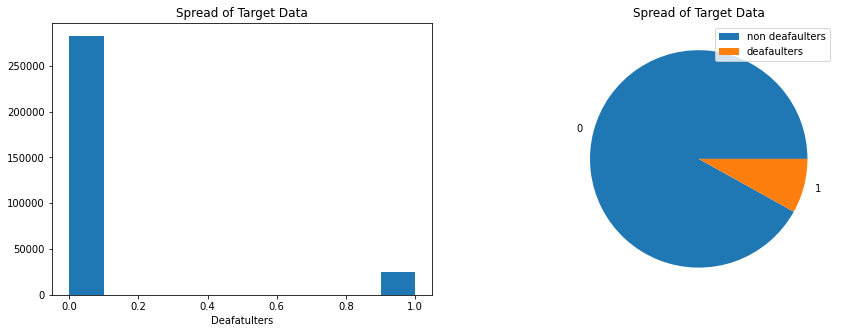

In [3]:
class_0 = df[y_name].value_counts()[0]
class_1 = df[y_name].value_counts()[1]
print("\n Non-defaulters :", round((class_0/(class_0+class_1))*100,2), '%')
print(" Defaulters  :", round((class_1/(class_0+class_1))*100,2),'%')


plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1,2,1)
plt.hist(df['TARGET'])
plt.title('Spread of Target Data')
plt.xlabel('Deafatulters')

#plot 2:
plt.subplot(1,2,2)
plt.pie(df['TARGET'].value_counts().values, labels= df['TARGET'].value_counts().index)
plt.title('Spread of Target Data')
plt.legend(['non deafaulters','deafaulters'])
plt.show()

# Primary Analysis

In [4]:
print('Primary analysis of main df \n')
df_desc = cf.primary_analysis(df)

df_desc.head()

Primary analysis of main df 



,name,unique,missing_cnt,missing_cnt_rto,type,skew,outlier_count
76,COMMONAREA_MEDI,3202,214865,69.872297,float64,5.419238,0.0
48,COMMONAREA_AVG,3181,214865,69.872297,float64,5.457305,0.0
62,COMMONAREA_MODE,3128,214865,69.872297,float64,5.620589,0.0
70,NONLIVINGAPARTMENTS_MODE,167,213514,69.432963,float64,16.251819,0.0
56,NONLIVINGAPARTMENTS_AVG,386,213514,69.432963,float64,15.541185,0.0


In [5]:
skewp_df= df_desc[df_desc['skew']>1]
skewn_df= df_desc[df_desc['skew']<-1]

print('Number of duplicate entries : ',df.duplicated().sum())
print('Number of variables with high skewnes : ',len(skewp_df) +len(skewn_df))
print('Number of variables with missing values : ',len(df_desc[df_desc['missing_cnt']>0]))
print('Number of variables with outliers : ',len(df_desc[df_desc['outlier_count']>0]))

Number of duplicate entries :  0
Number of variables with high skewnes :  87
Number of variables with missing values :  67
Number of variables with outliers :  40


### Observed corrections

1. 'XNA' category from Gender is removed

In [6]:
print(df['CODE_GENDER'].value_counts())

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


In [7]:
df = df[df['CODE_GENDER']!= 'XNA']

### Missing value Analysis

In [8]:
df_desc[['name','missing_cnt','missing_cnt_rto']][df_desc['missing_cnt_rto']>45]

,name,missing_cnt,missing_cnt_rto
76,COMMONAREA_MEDI,214865,69.872297
48,COMMONAREA_AVG,214865,69.872297
62,COMMONAREA_MODE,214865,69.872297
70,NONLIVINGAPARTMENTS_MODE,213514,69.432963
56,NONLIVINGAPARTMENTS_AVG,213514,69.432963
84,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
86,FONDKAPREMONT_MODE,210295,68.386172
68,LIVINGAPARTMENTS_MODE,210199,68.354953
54,LIVINGAPARTMENTS_AVG,210199,68.354953
82,LIVINGAPARTMENTS_MEDI,210199,68.354953



 
 	 	 Visualisation of missing columns 

 
 	 	 Visualisation of missing columns by count 


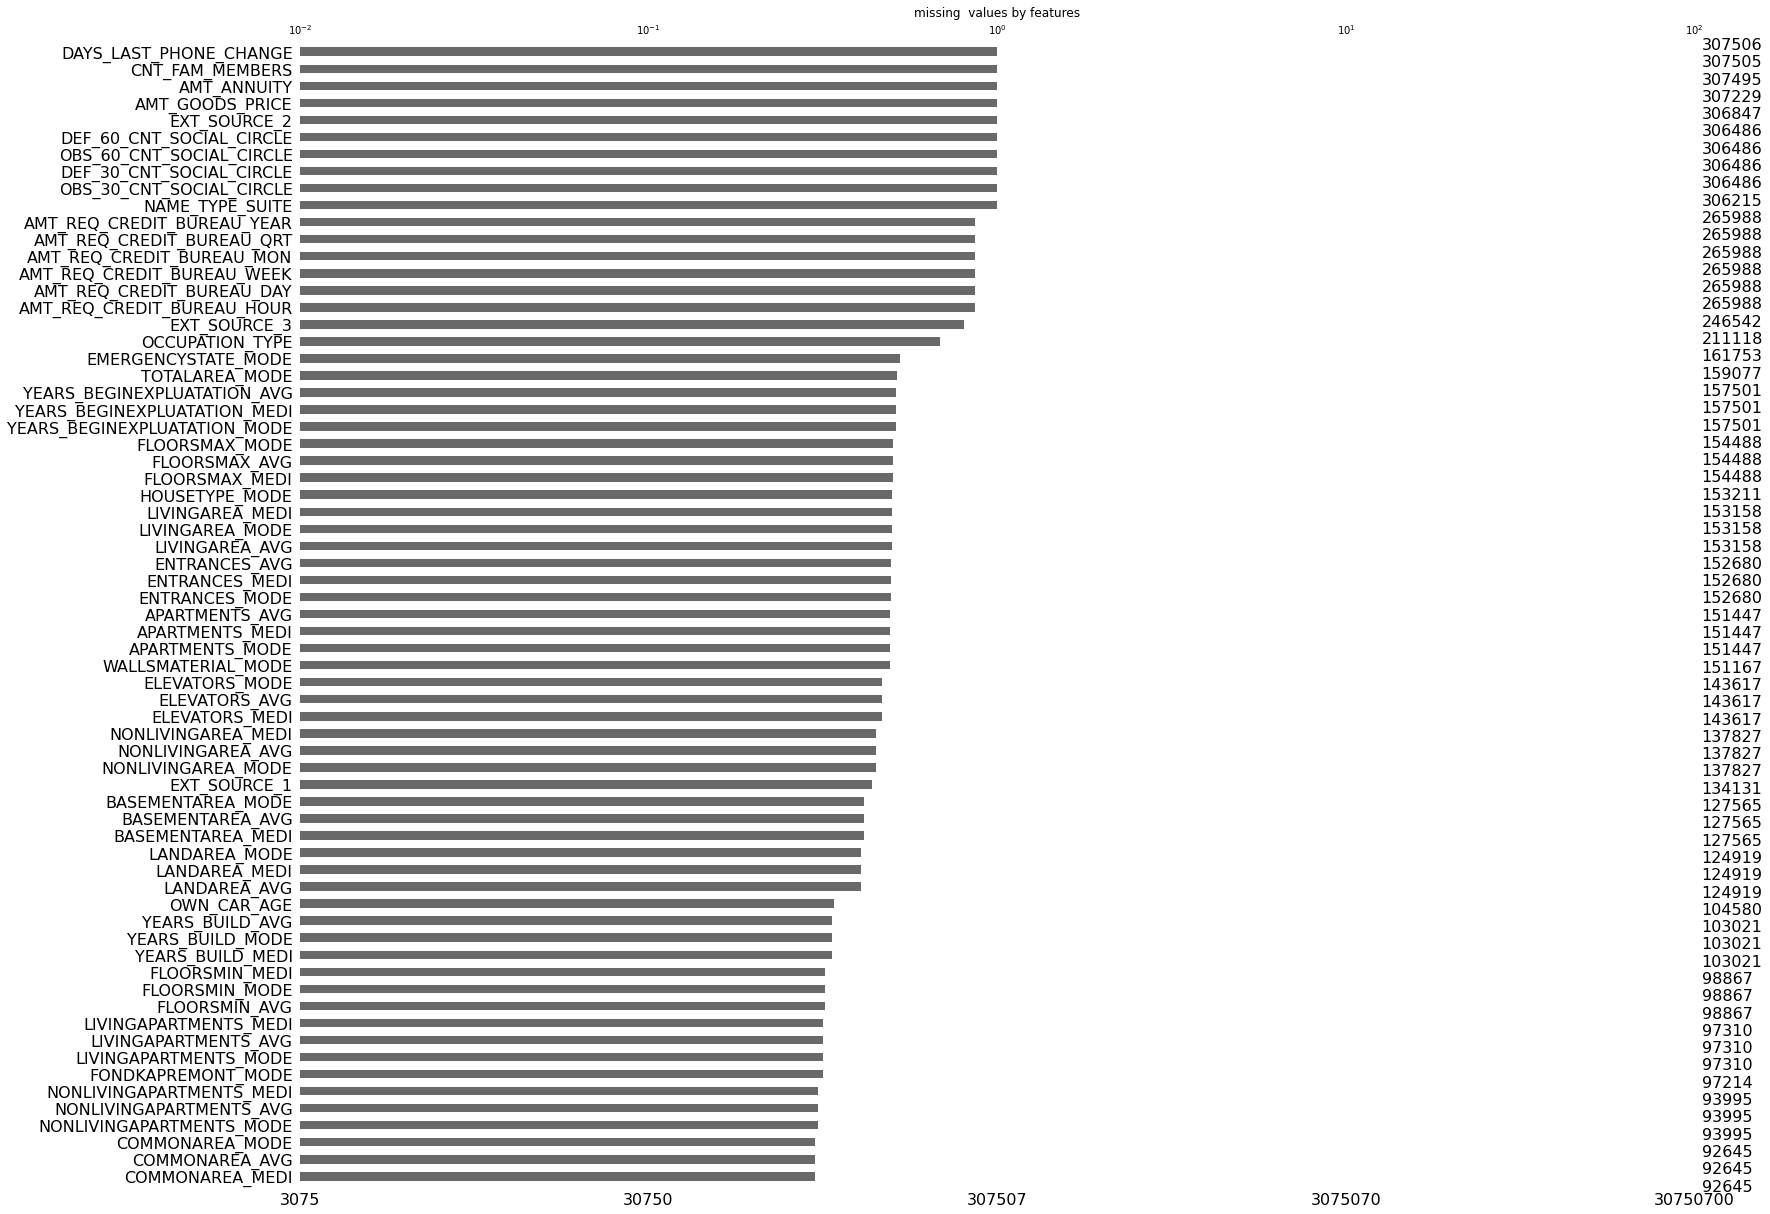

In [9]:
#Analysing of missing values using graphs 

print('\n \n \t \t Visualisation of missing columns ')
missing_cols = df_desc[df_desc['missing_cnt']>0]['name'].values
livarea = [ col for col in df.columns if 'AVG' in col or 'MEDI' in col or 'MODE' in col]
other_cols = set(missing_cols) - set(livarea)


print('\n \n \t \t Visualisation of missing columns by count ')
plt.title('missing  values by features')
vp.miss_viz(df[missing_cols],kind ='bar')


 
 	 	 Visualisation of missing columns by pattern 


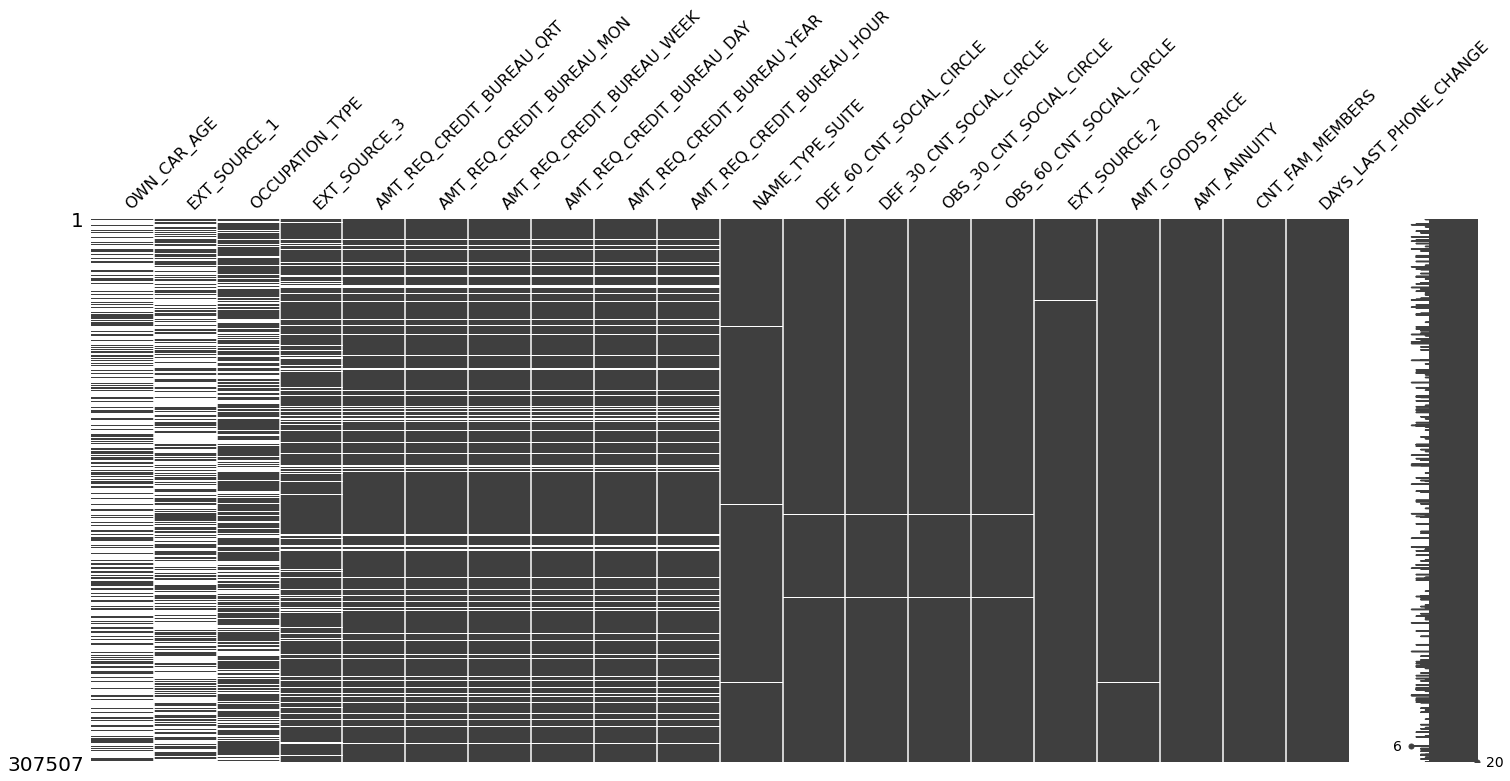

In [10]:
print('\n \n \t \t Visualisation of missing columns by pattern ')
vp.miss_viz(df[other_cols],kind ='matrix')


 
 	 	 Visualisation of missing columns by association 


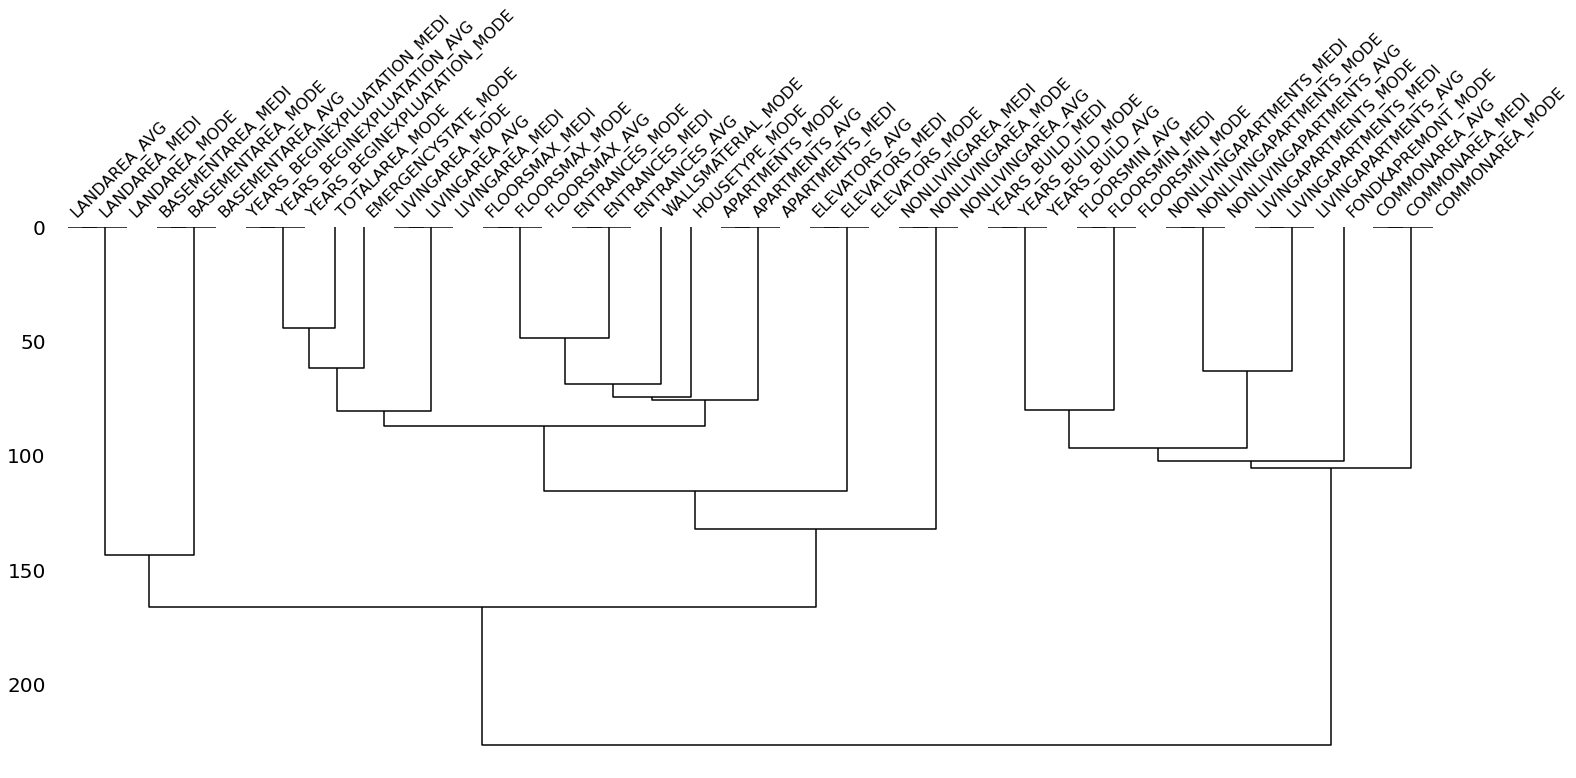

In [11]:
print('\n \n \t \t Visualisation of missing columns by association ')
vp.miss_viz(df[livarea],kind ='dend')


 
 	 	 Visualisation of missing columns by association 


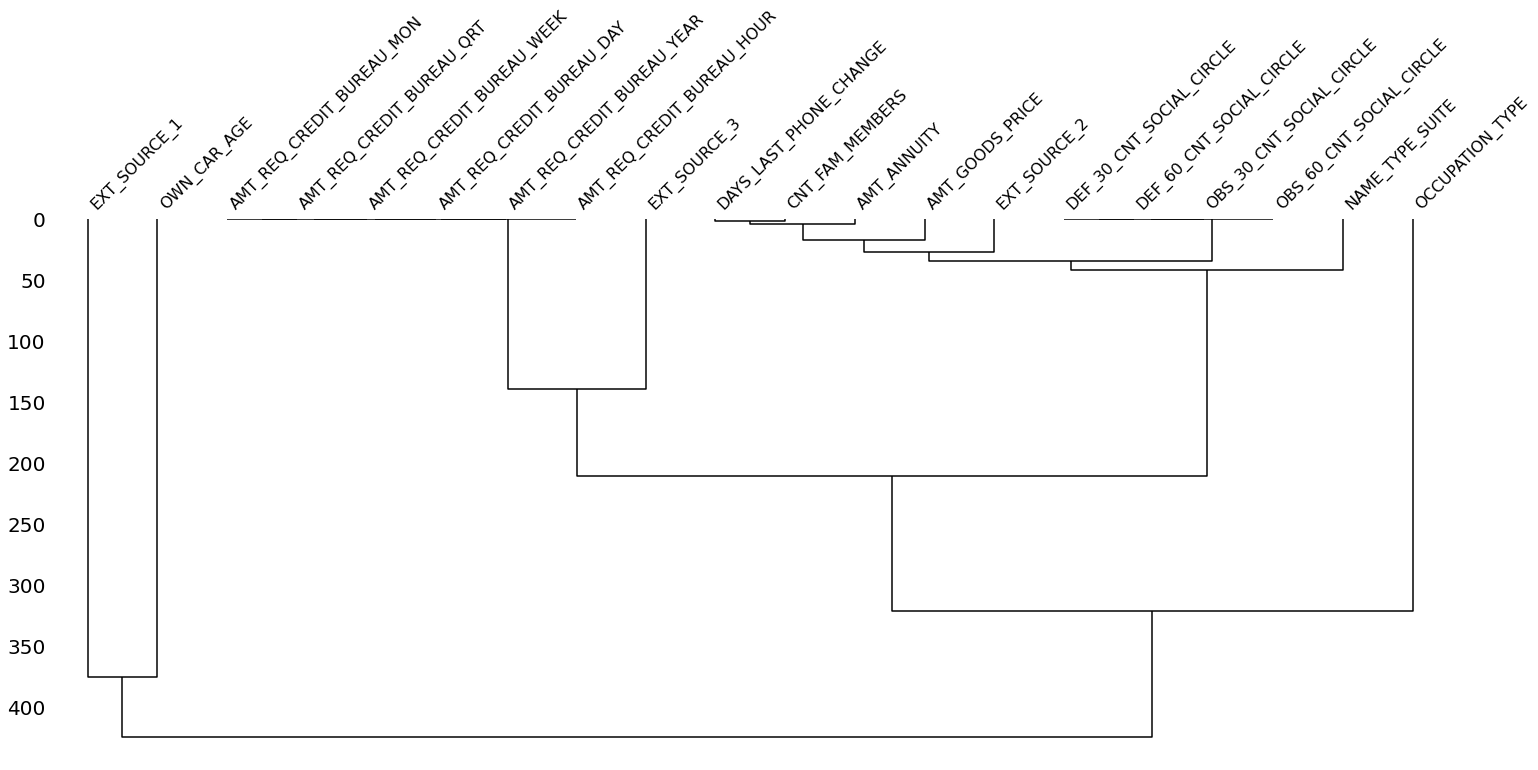

In [12]:
print('\n \n \t \t Visualisation of missing columns by association ')
vp.miss_viz(df[other_cols],kind ='dend')


 
 	 	 Visualisation of missing columns by correlation 


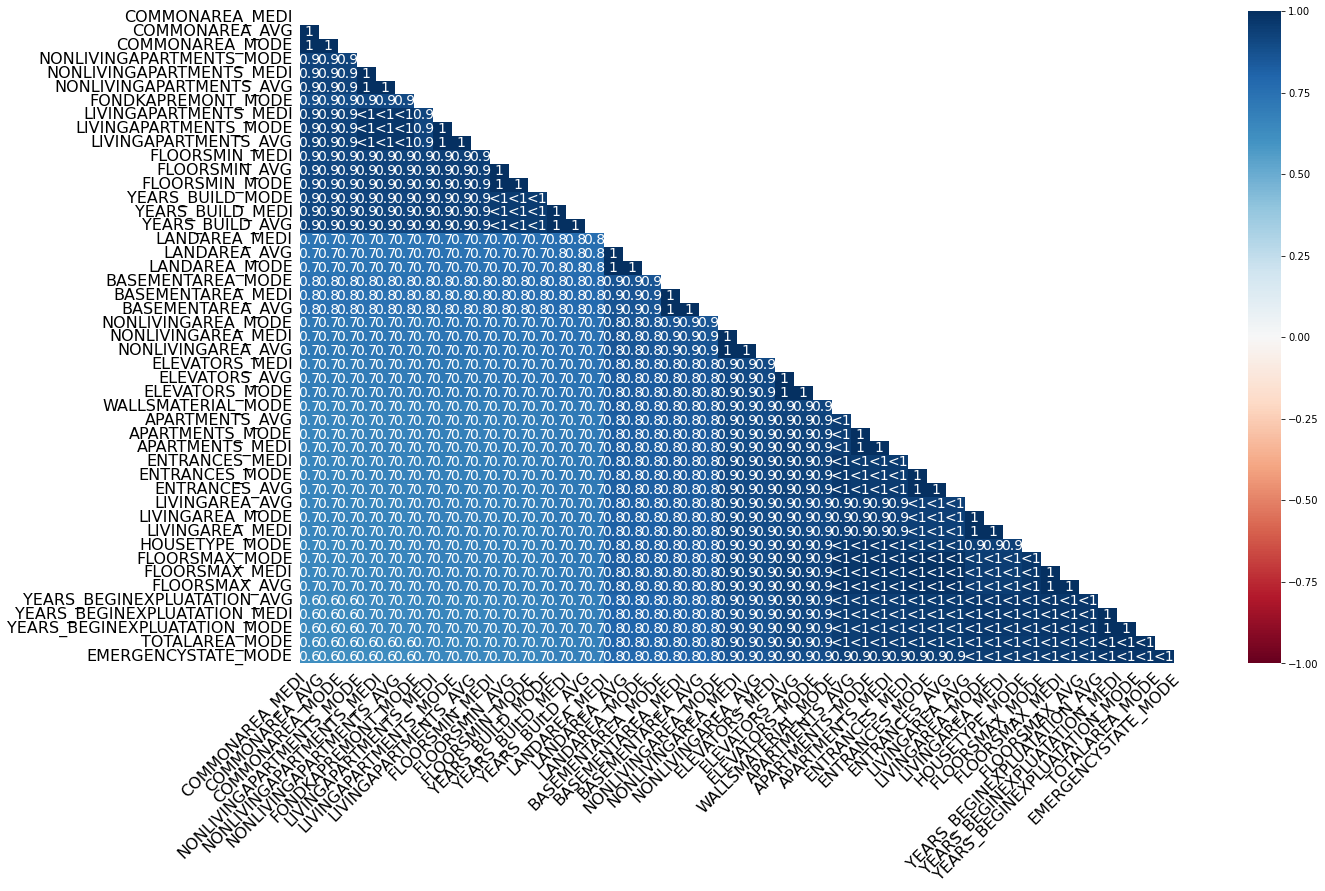

In [13]:
print('\n \n \t \t Visualisation of missing columns by correlation ')
vp.miss_viz(df[livarea],kind ='corr')


 
 	 	 Visualisation of missing columns by correlation 


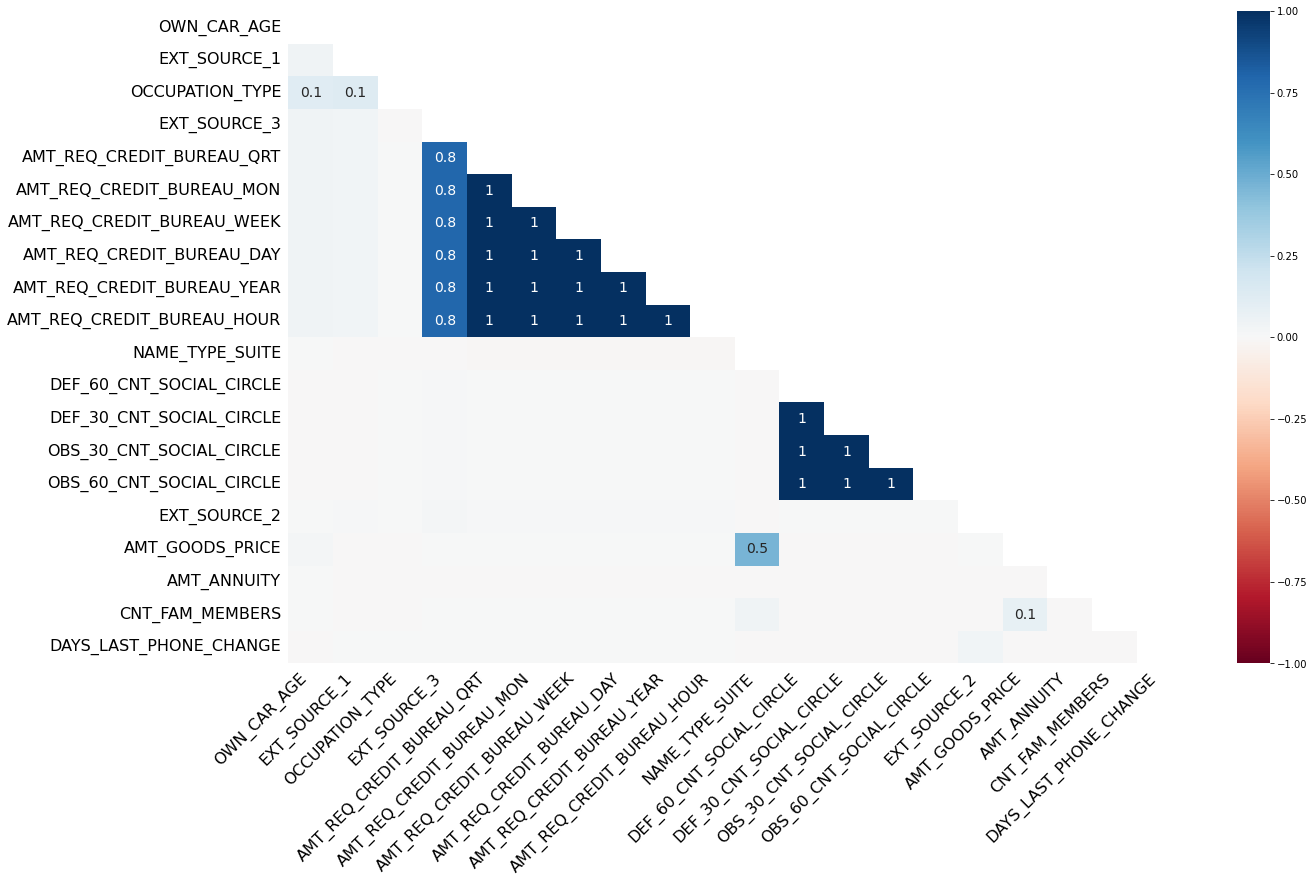

In [14]:
print('\n \n \t \t Visualisation of missing columns by correlation ')
vp.miss_viz(df[other_cols],kind ='corr')

In [15]:
miss_unique = np.where(df_desc[df_desc['missing_cnt_rto']>0].duplicated(subset=['missing_cnt_rto'])==True)

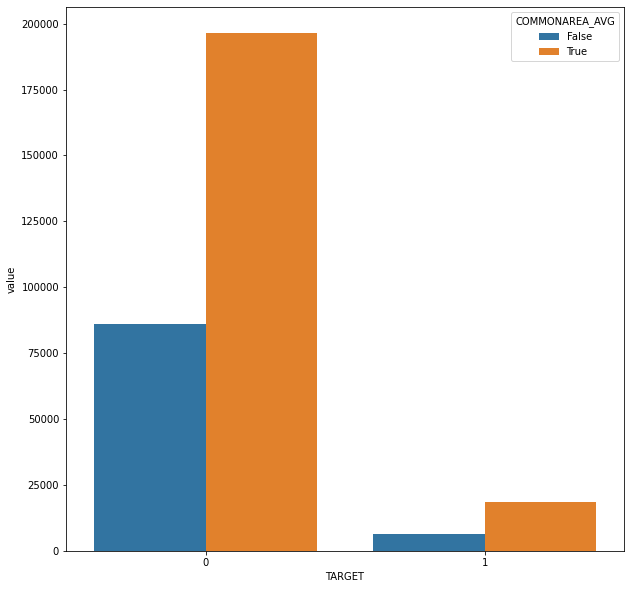

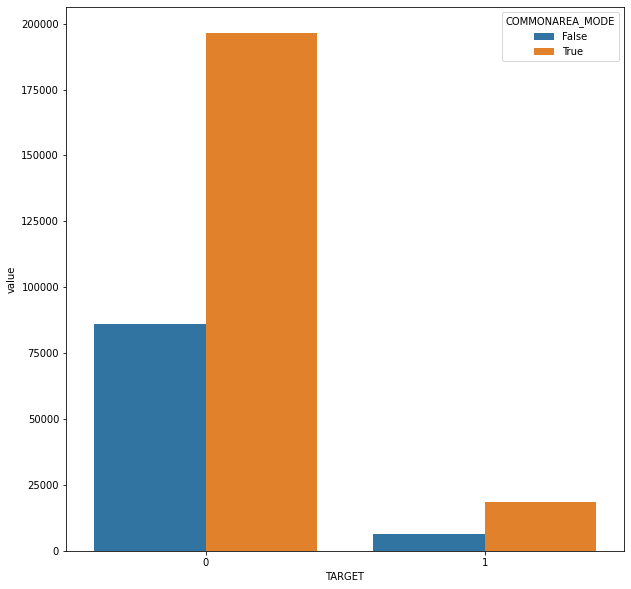

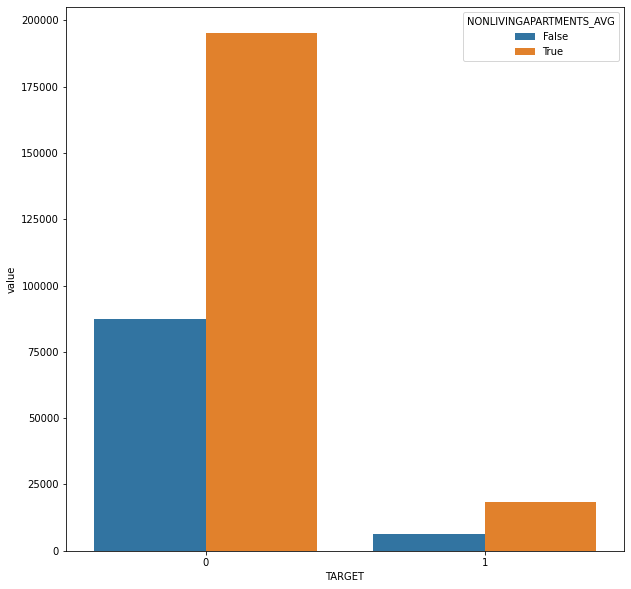

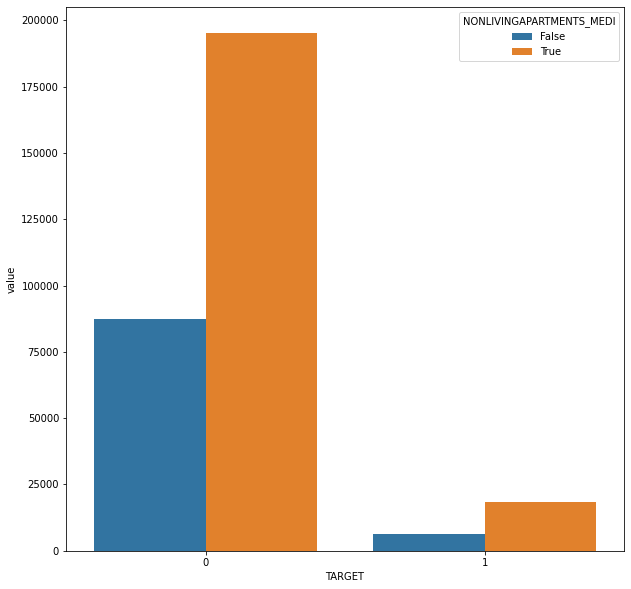

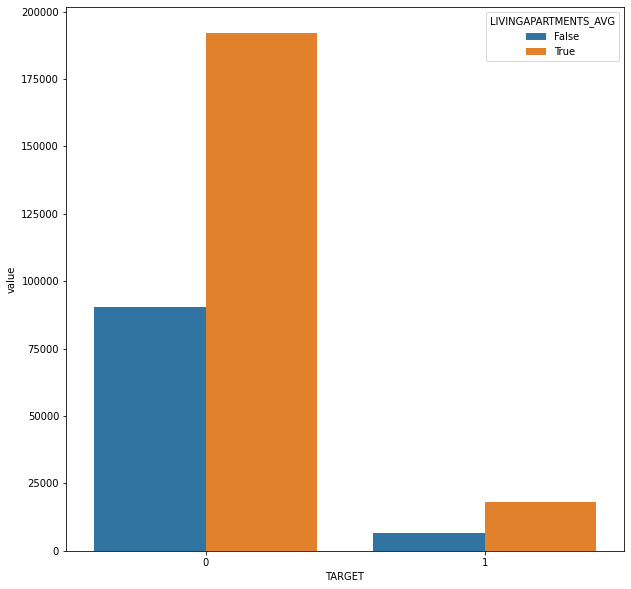

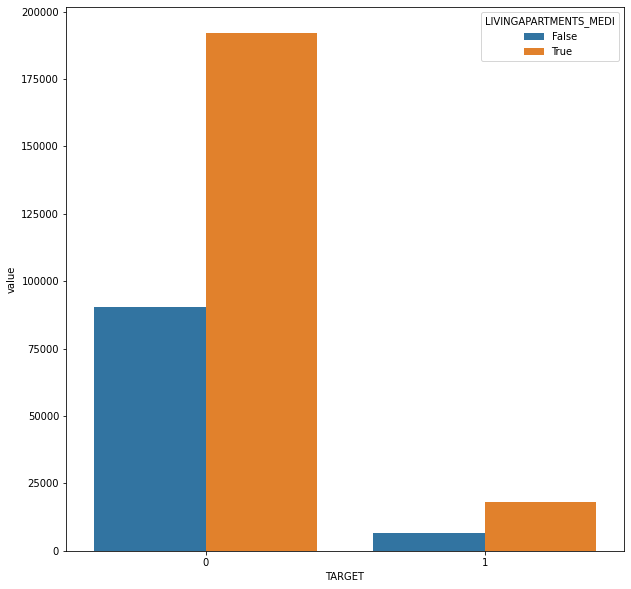

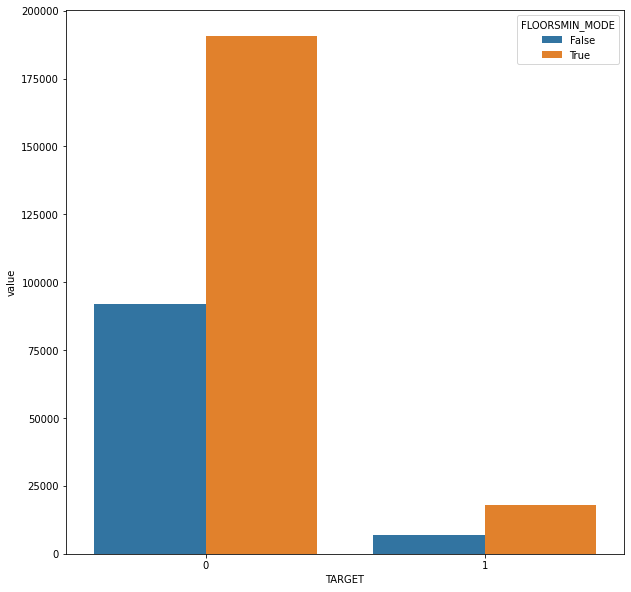

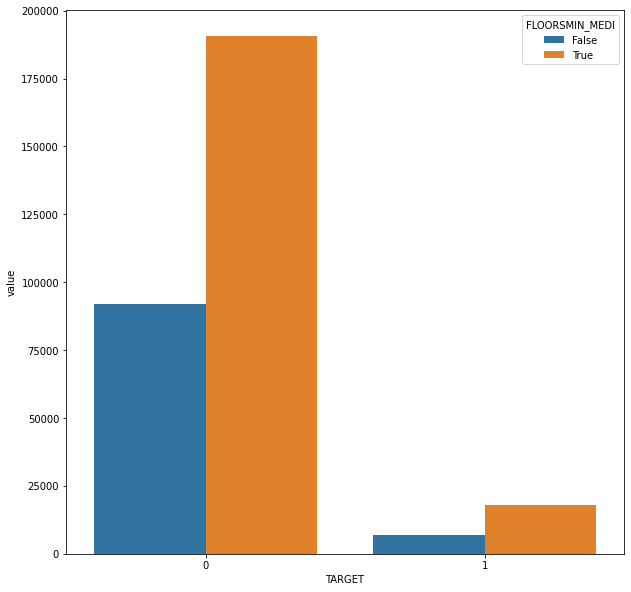

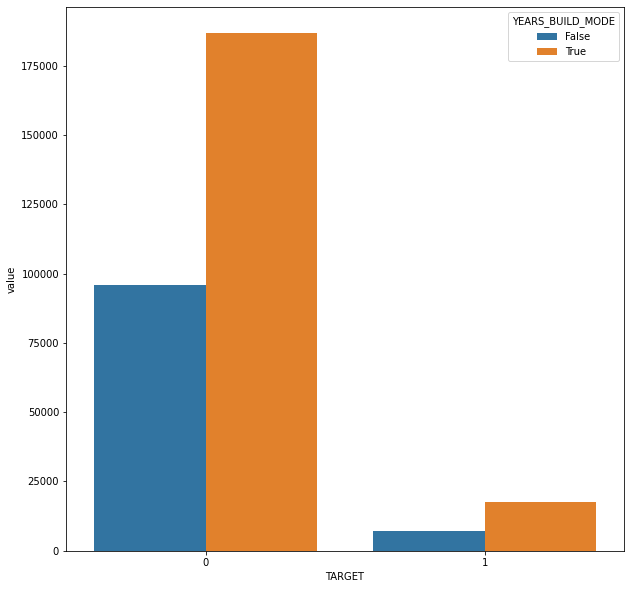

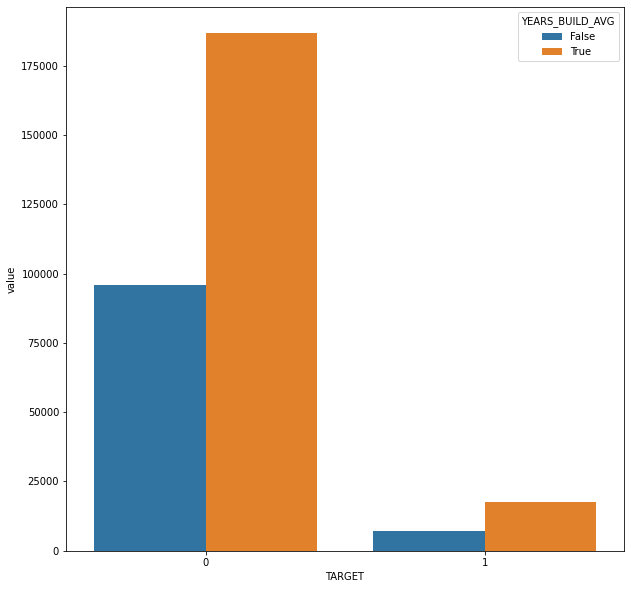

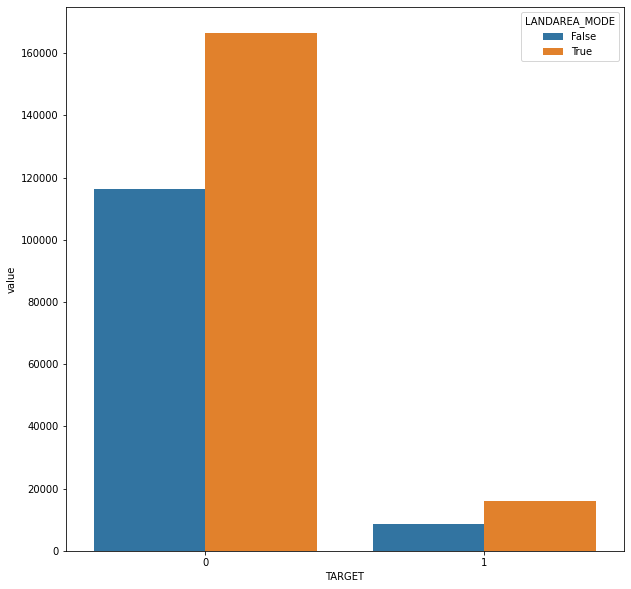

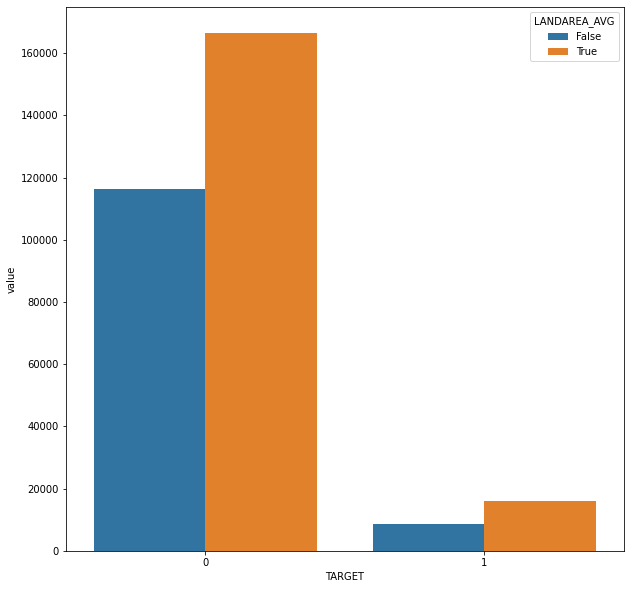

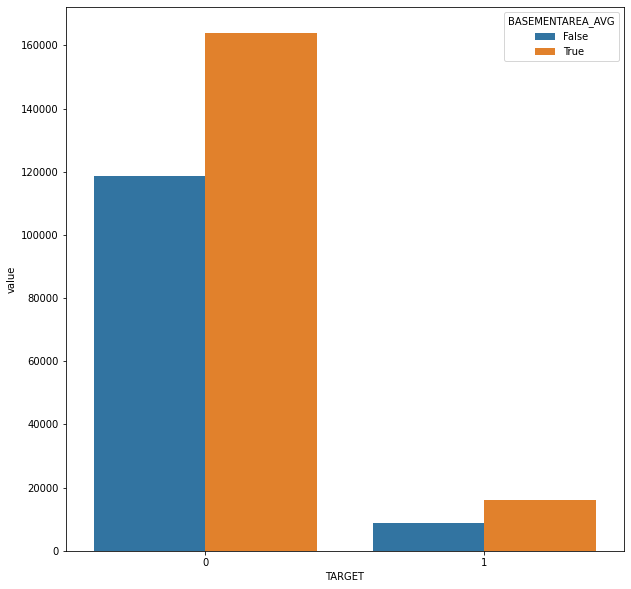

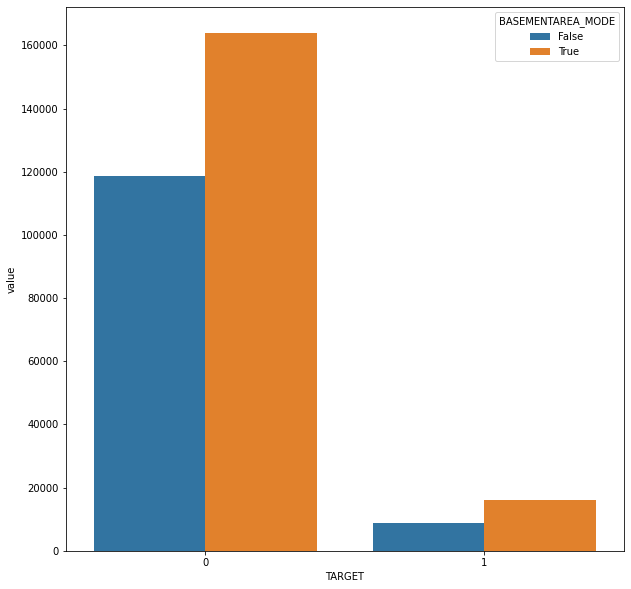

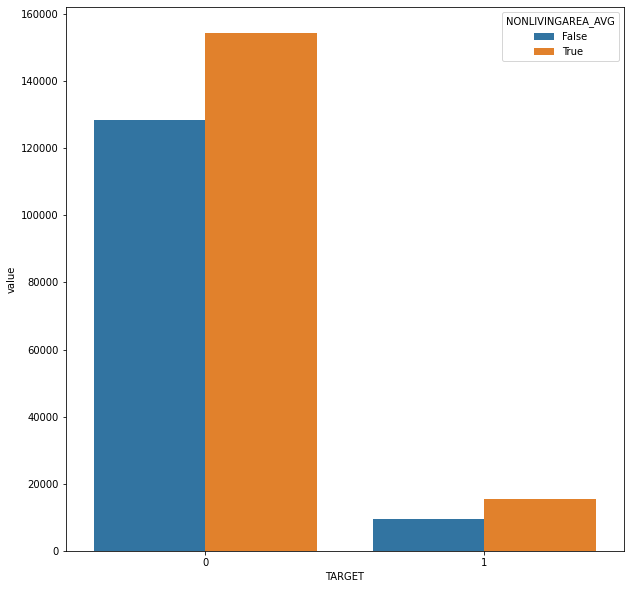

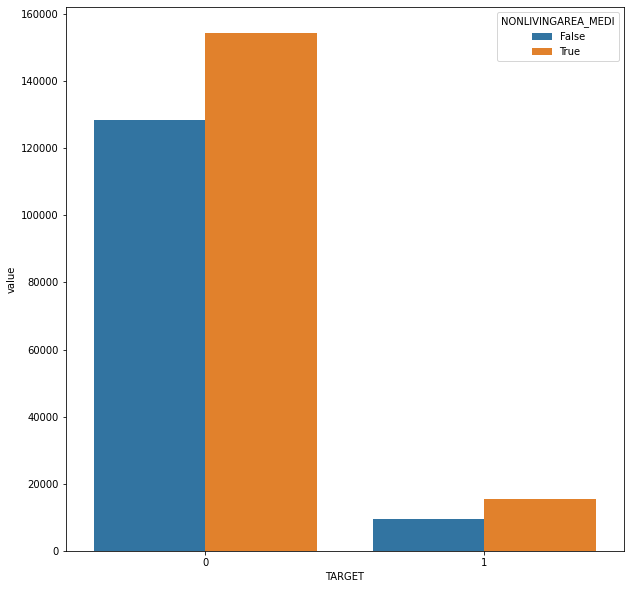

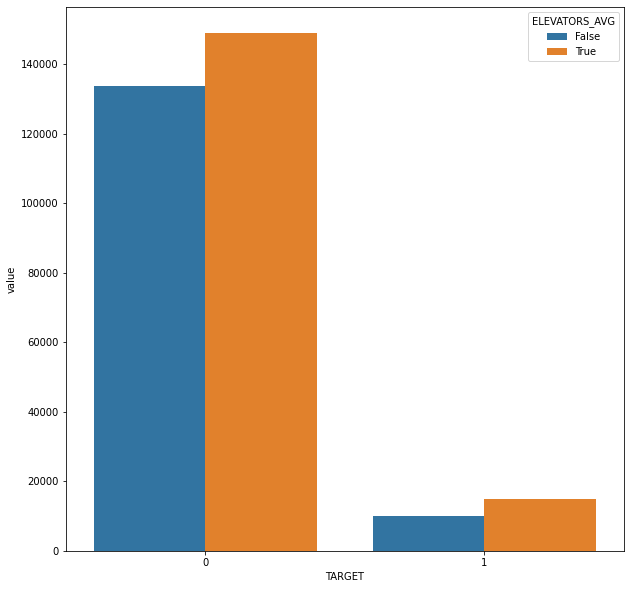

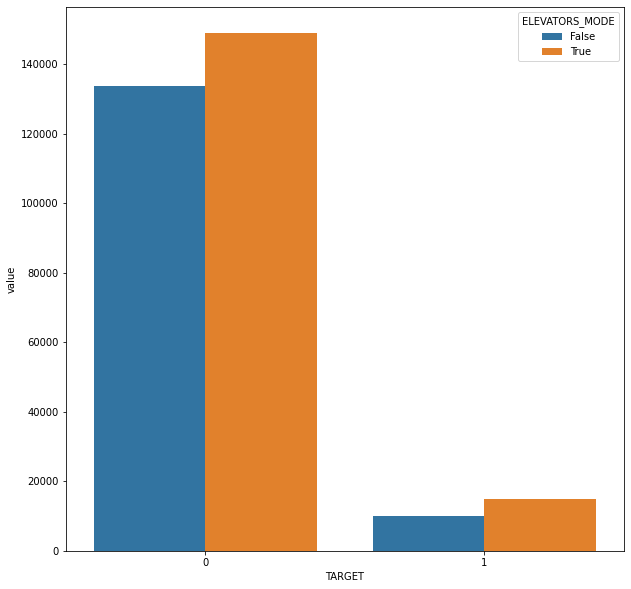

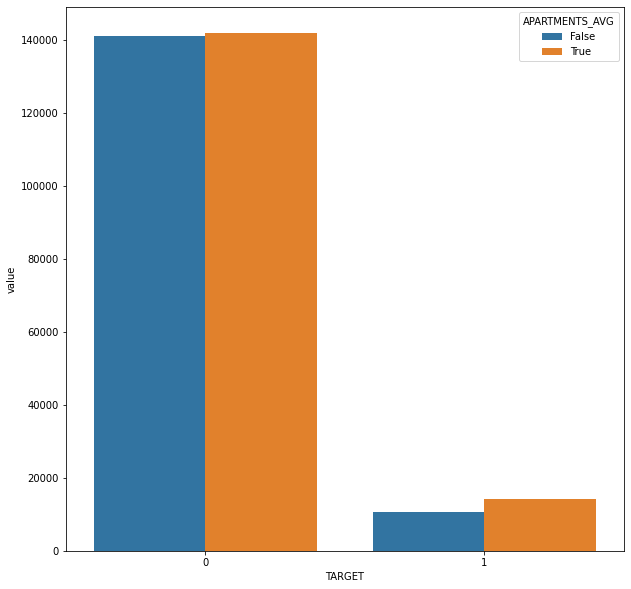

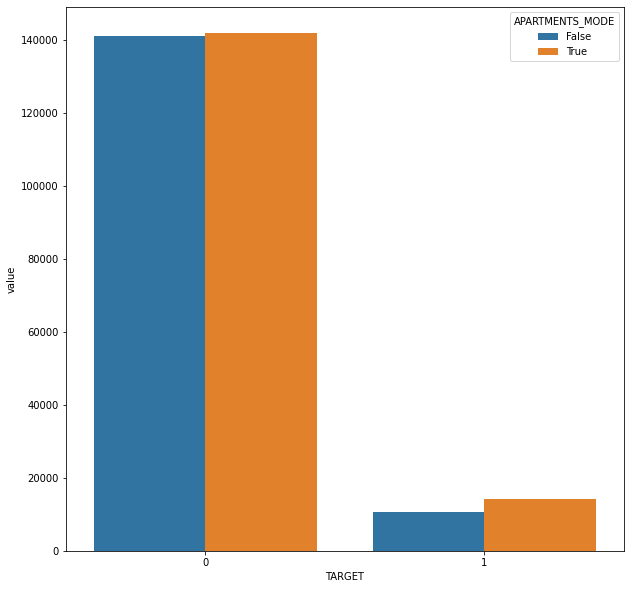

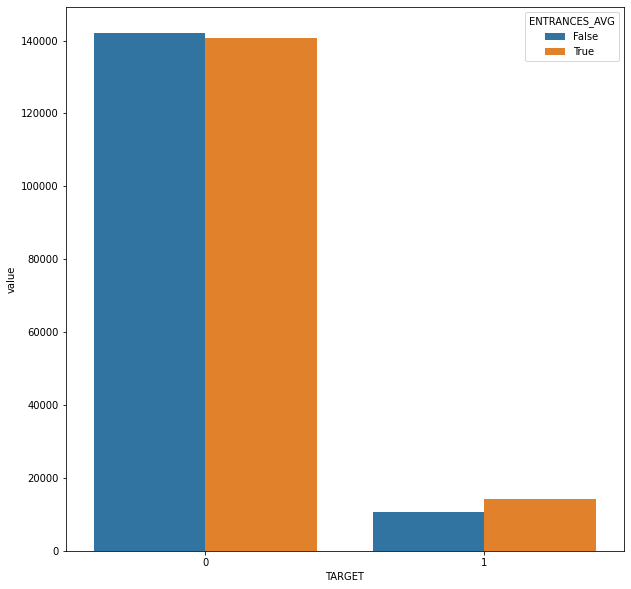

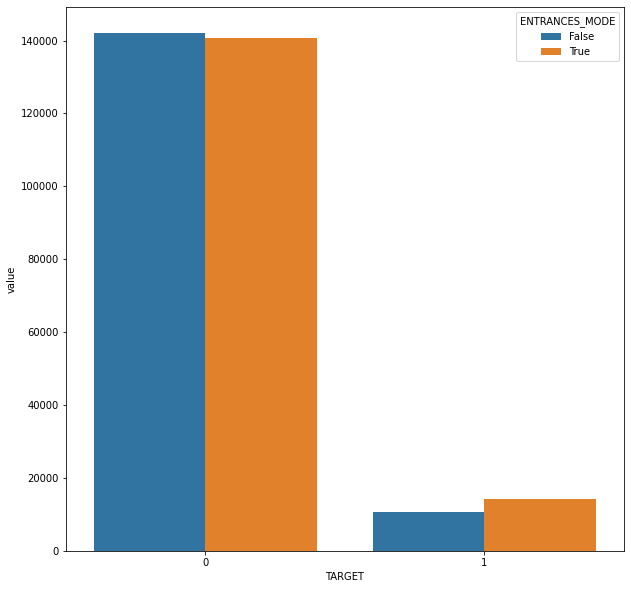

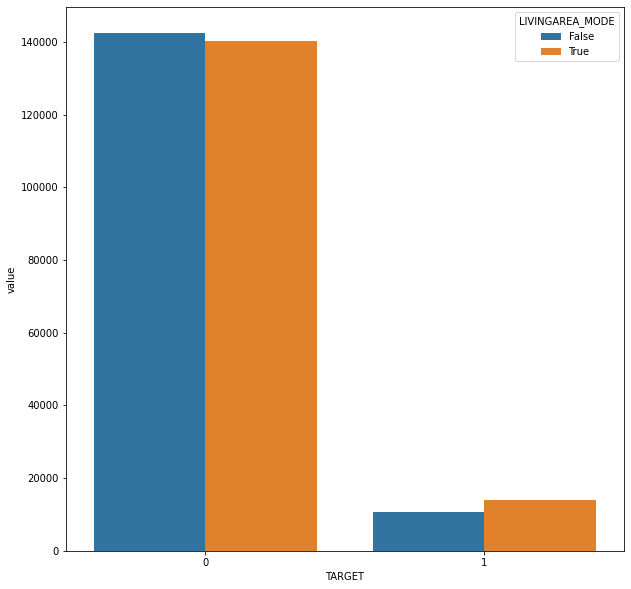

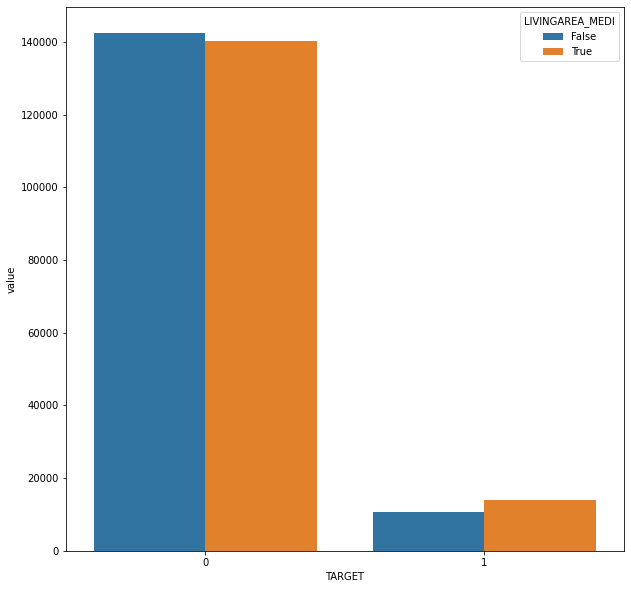

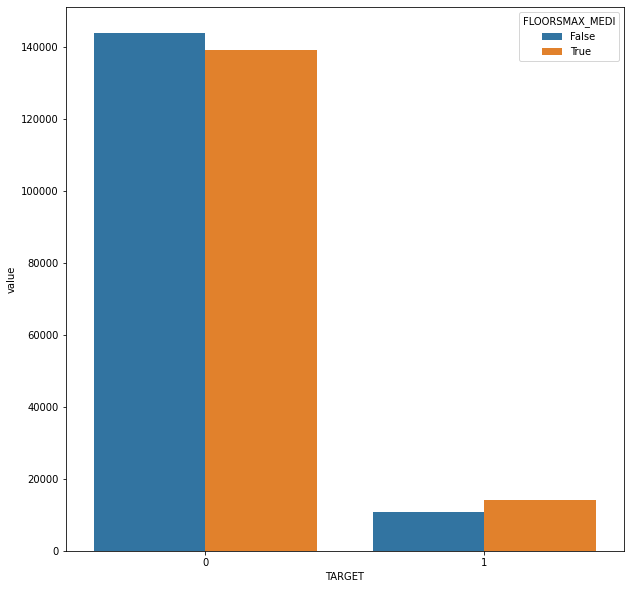

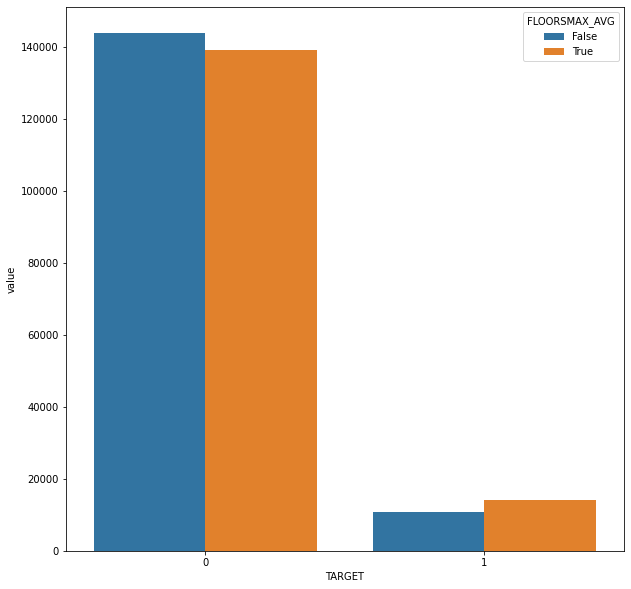

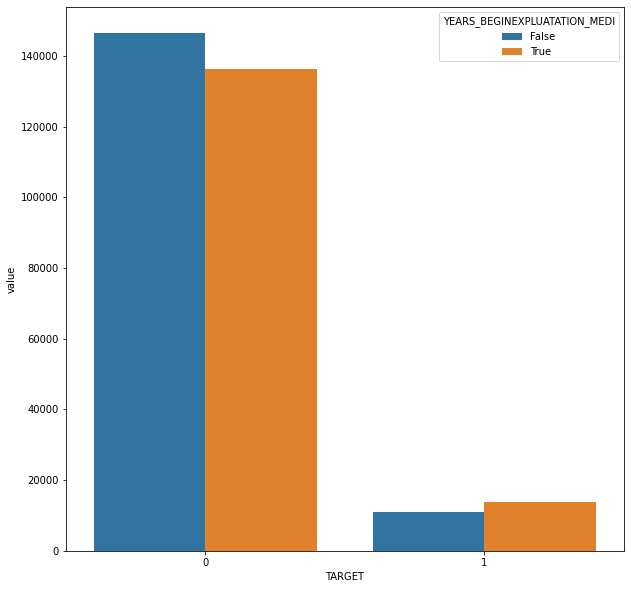

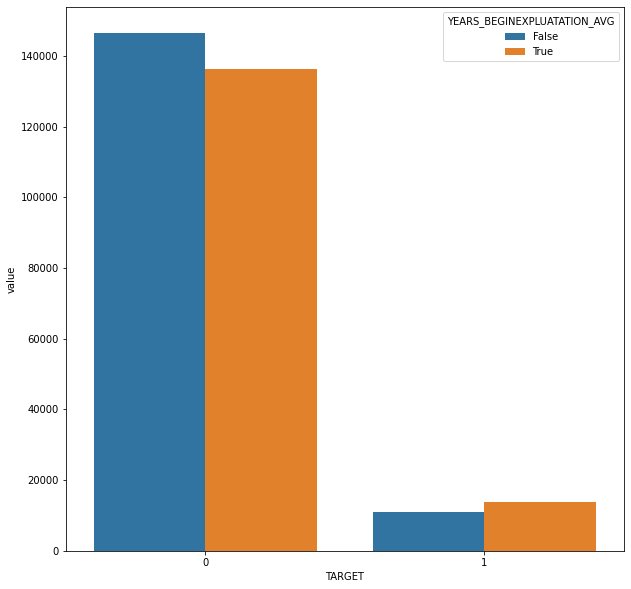

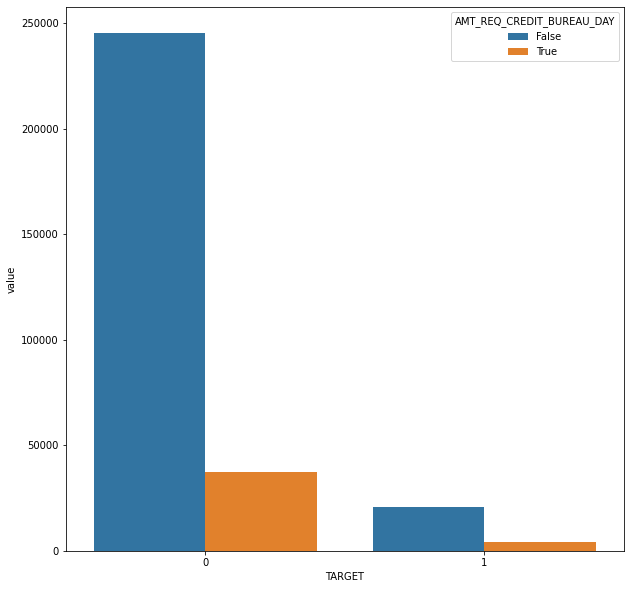

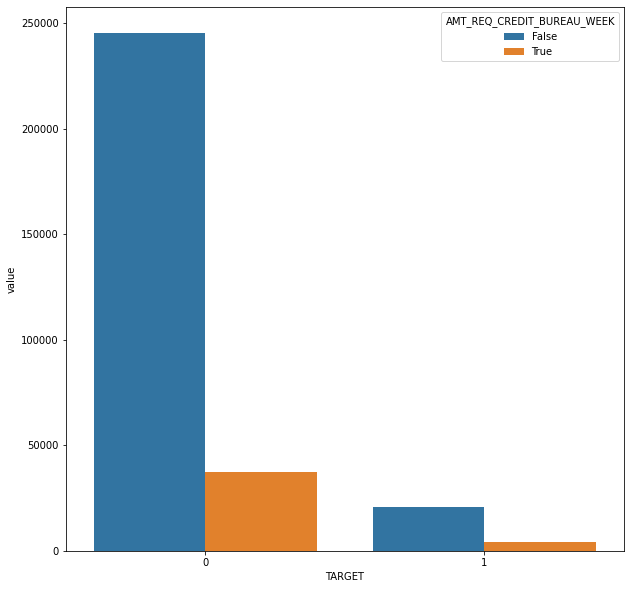

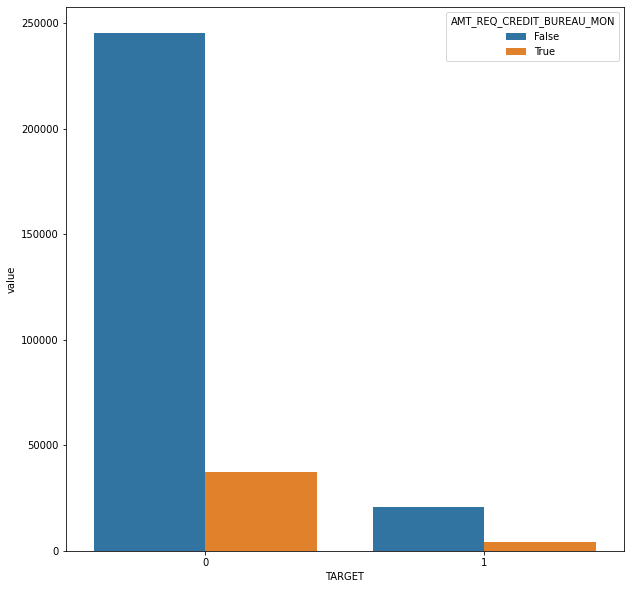

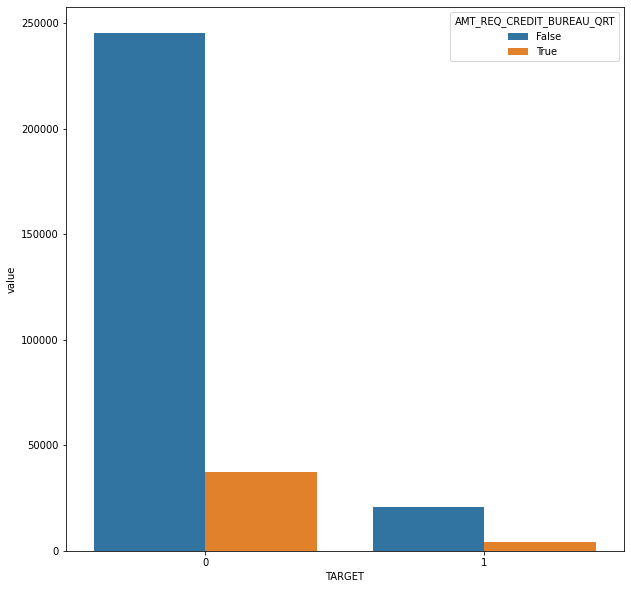

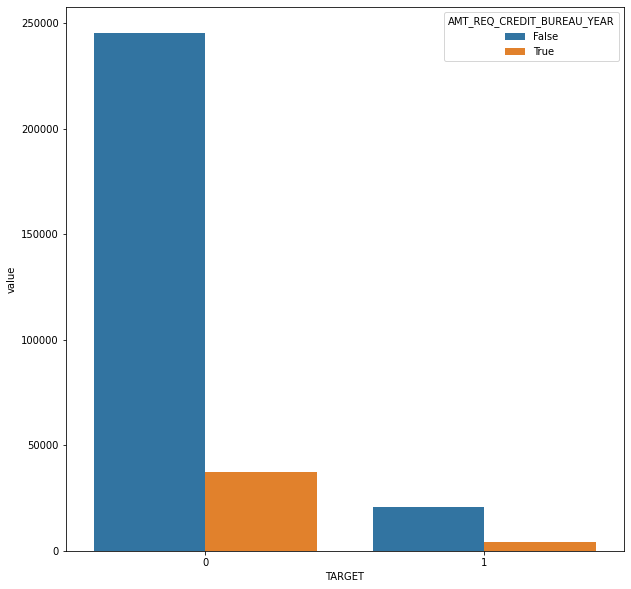

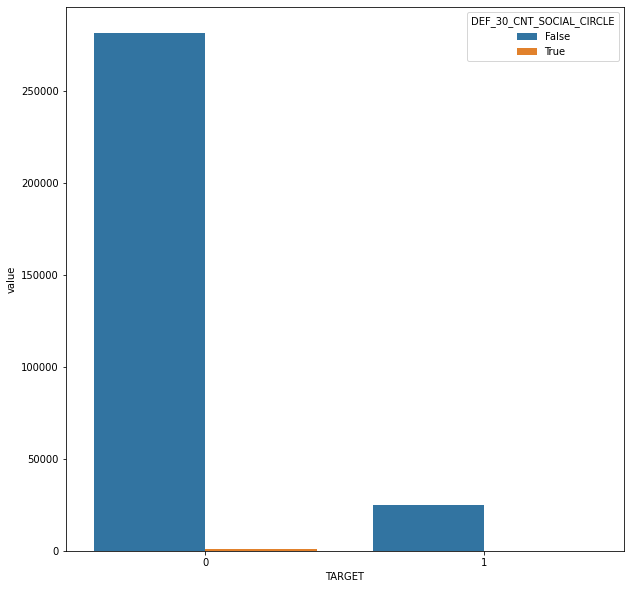

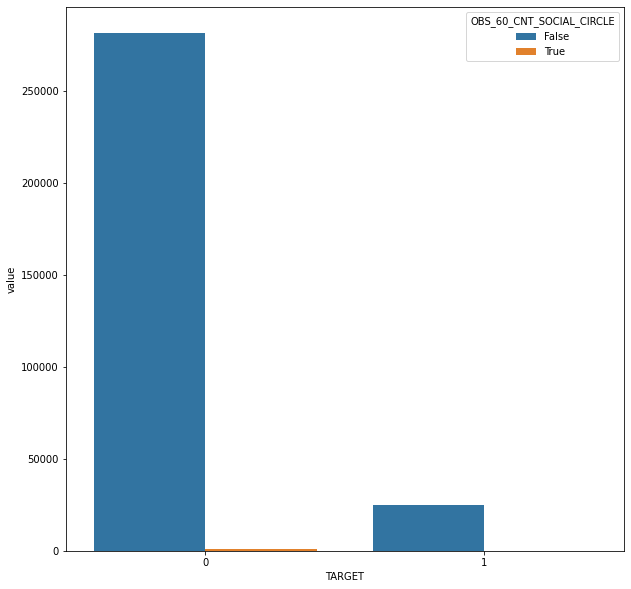

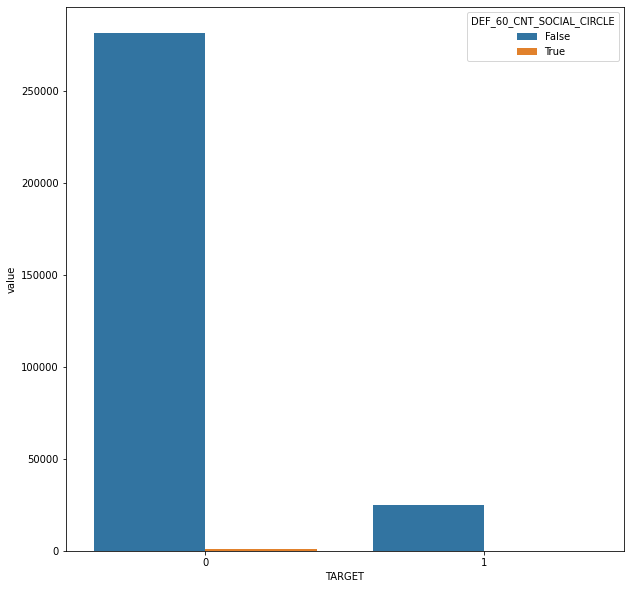

In [16]:
vp.missing_per_class(df,df_desc.iloc[miss_unique]['name'])

In [17]:
#missing not at random
print('\n value_count for FLAG_OWN_CAR for "N" = ',df['FLAG_OWN_CAR'].value_counts()[0])
print('\n total missing values in OWN_CAR_AGE = ',df['OWN_CAR_AGE'].isnull().sum())


 value_count for FLAG_OWN_CAR for "N" =  202922

 total missing values in OWN_CAR_AGE =  202927


Interpretations :

1. The features with missing value greater than 45% can be removed since the imputation may lead to bias or reduced explained variance

2. The features which are missing not at random which has a patteren and high correlation with few other features:
    i) AMT_REQ_CREDIT...
    ii) ....SOCIAL_CIRCLE
    
3. Proportion of missing values among the both classes are balanced

Treating Missing Values

In [18]:
shp_bfr = df.shape

print('Shape of df before dropping = ',df.shape)

#values for age of car is assigned to -1 when one has no car
df.loc[df['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'] = -1
df['OWN_CAR_AGE'].fillna(0, inplace= True)

#droped columns with missing value > 50% and are completely missing at ranom 
df = cf.missing_value_analysis(df, 0.5)
print('Shape of df after dropping = ',df.shape)

#dropping as these are missing not at random
df = df.dropna(axis=0, how='any', subset=['AMT_REQ_CREDIT_BUREAU_HOUR','OBS_60_CNT_SOCIAL_CIRCLE'], inplace=False)

#filling missing value with np.nan for missing at random
df['OCCUPATION_TYPE'].fillna('unknown', inplace = True)

shp_aftr = df.shape

print("total number of dropped rows in % =", ((shp_bfr[0]-shp_aftr[0])/shp_aftr[0])*100,"%")
print("total number of dropped columns = ",shp_bfr[1] - shp_aftr[1])

Shape of df before dropping =  (307507, 122)
Total number of dropped columns for threshold 0.5: 40
Total number of columns with missing value :26
Columns dropped : ['EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']
Shape of df after dropping =  (307507

### Missing valaue treatment 

Dropping the columns which have missing value greater than 45%

dropped_columns:

'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE'

Imputing other missing value by (-999)


### OUTLIER Analysis and Treatment

In [19]:
df_desc[['name','outlier_count']][df_desc['outlier_count']>1]

,name,outlier_count
6,CNT_CHILDREN,4272.0
102,FLAG_DOCUMENT_8,25024.0
96,FLAG_DOCUMENT_2,13.0
98,FLAG_DOCUMENT_4,25.0
99,FLAG_DOCUMENT_5,4648.0
100,FLAG_DOCUMENT_6,27078.0
101,FLAG_DOCUMENT_7,59.0
103,FLAG_DOCUMENT_9,1198.0
115,FLAG_DOCUMENT_21,103.0
104,FLAG_DOCUMENT_10,7.0


### Visual Analysis for outliers

Outliers analysis


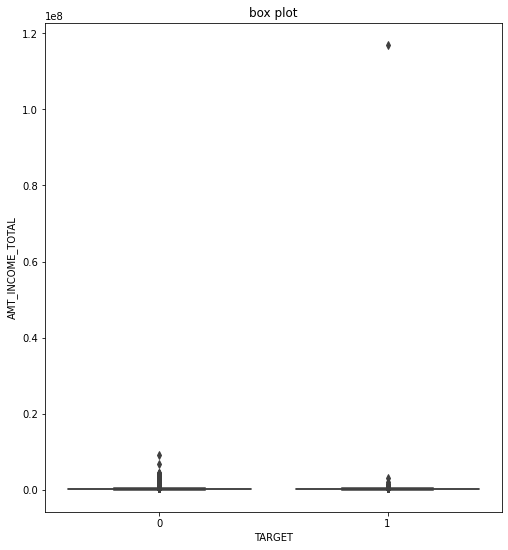

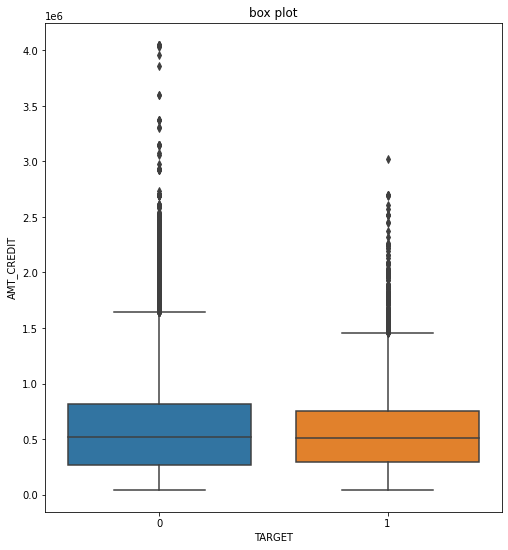

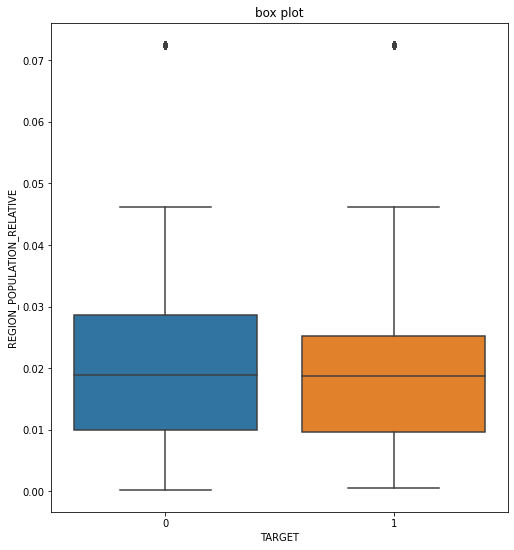

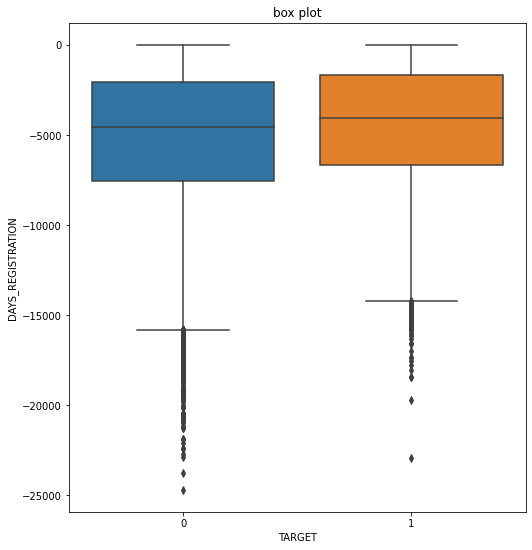

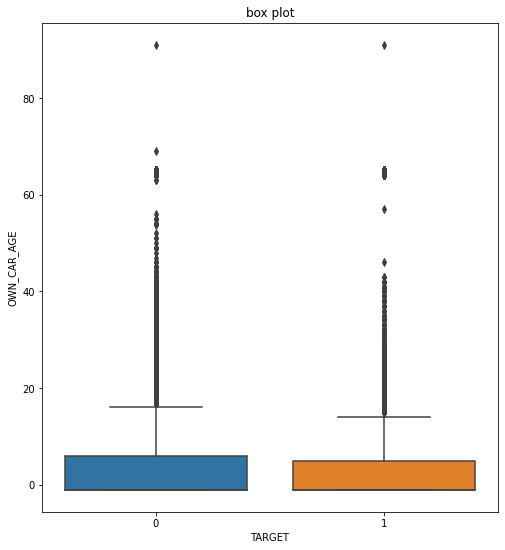

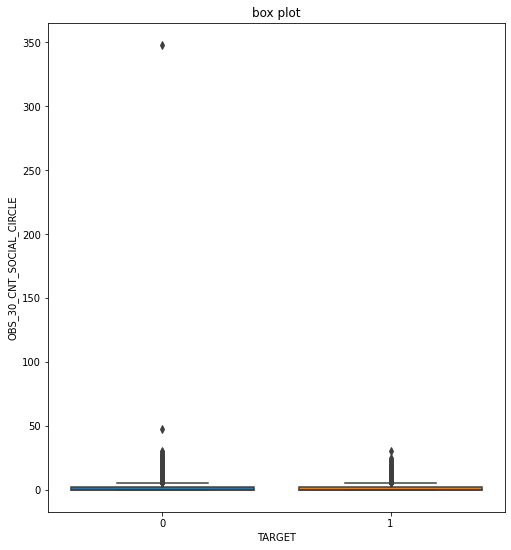

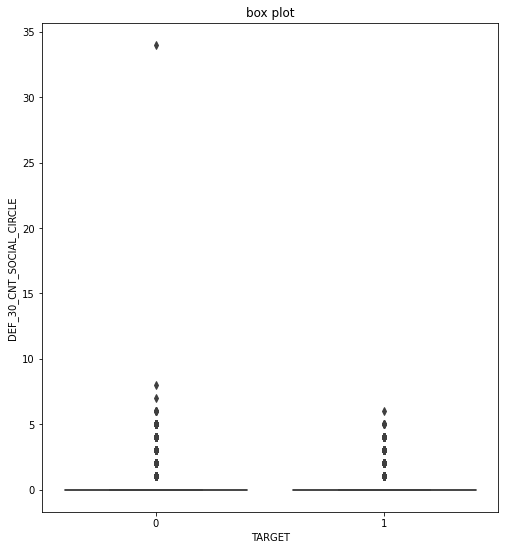

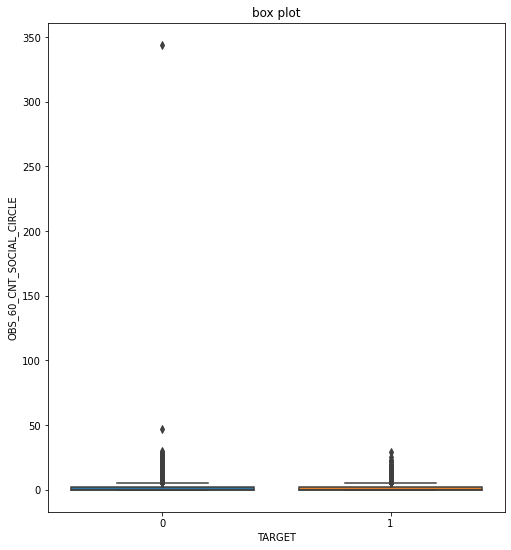

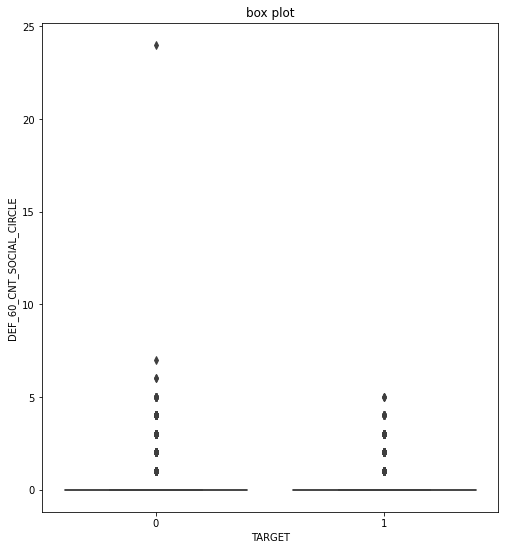

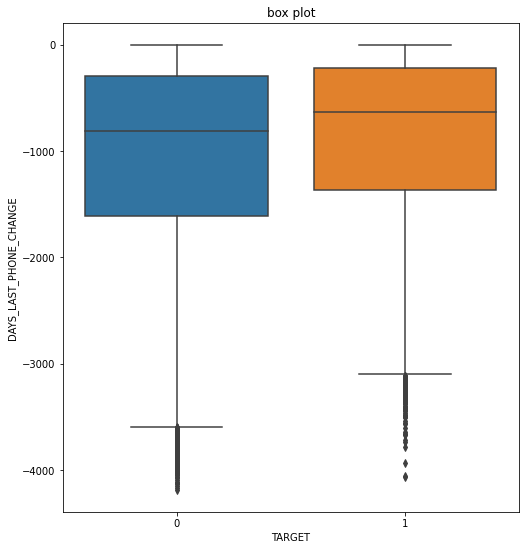

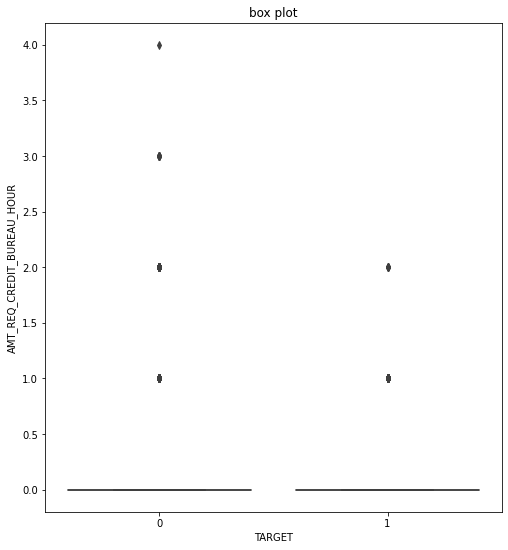

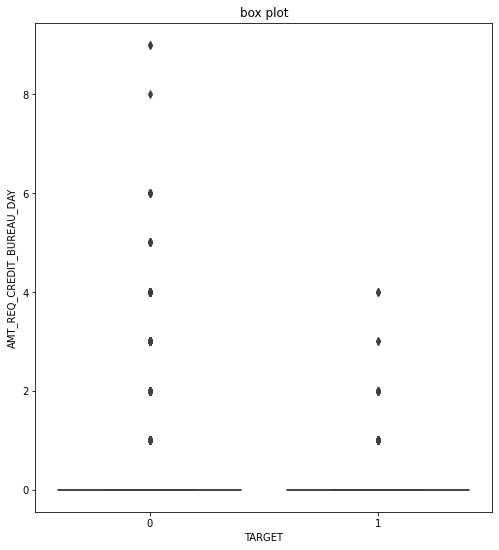

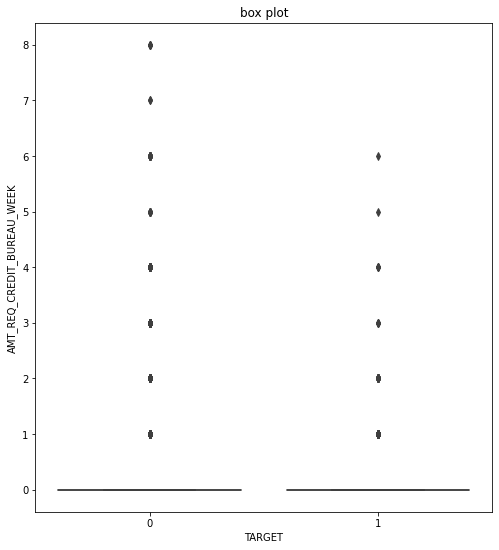

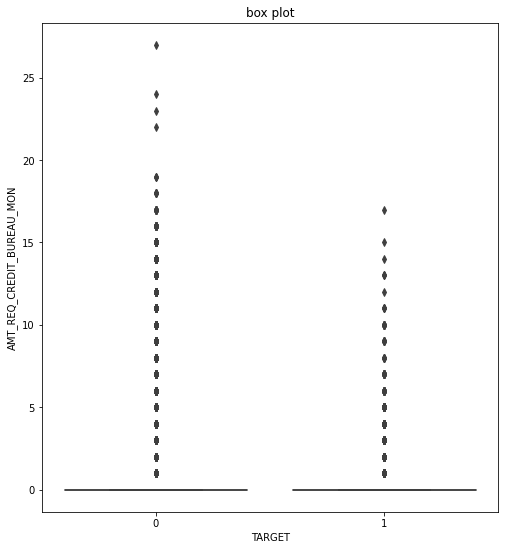

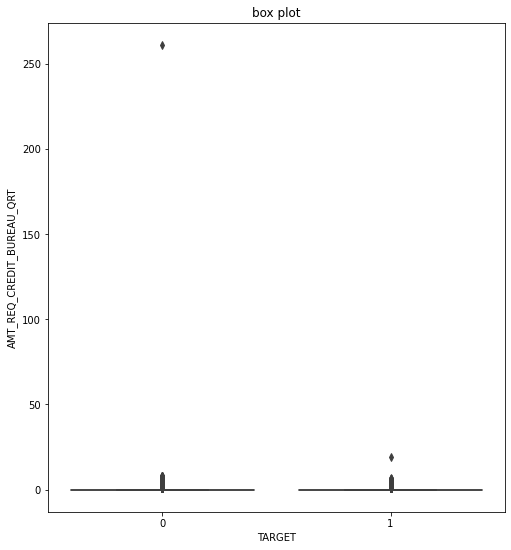

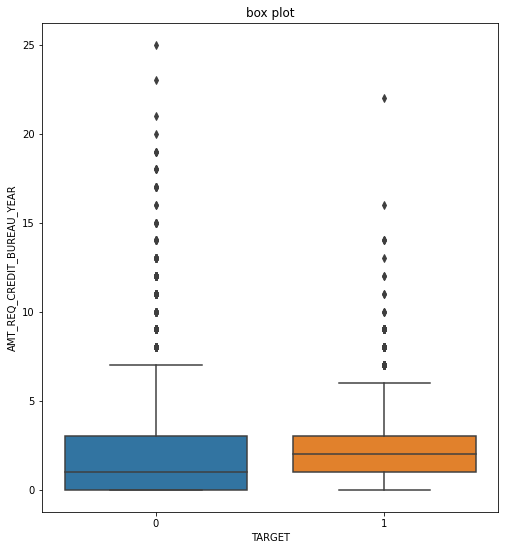

In [20]:
print('Outliers analysis')
vp.plot_outliers(df)

### outlier treatment

'DAYS_EMPLOYED' has a outlier in different direction of majority of data hince treated as missing value

In [21]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

df.drop(df[df['AMT_INCOME_TOTAL'] > 11000000].index, inplace = True)   
df.drop(df[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 300].index, inplace = True)   
df.drop(df[df['DEF_30_CNT_SOCIAL_CIRCLE'] > 30].index, inplace = True)   
df.drop(df[df['OBS_60_CNT_SOCIAL_CIRCLE'] > 300].index, inplace = True)   
df.drop(df[df['DEF_60_CNT_SOCIAL_CIRCLE'] > 20].index, inplace = True)   
df.drop(df[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 200].index, inplace = True)   

### Feature Engineering

In [22]:
num_df = df.select_dtypes(exclude='O')

edu_dict = {'Incomplete higher':0,
            'Lower secondary':1,
            'Secondary / secondary special':2,
            'Higher education':3,
            'Academic degree':4
            }

docs = [col for col in np.array(df.columns) if 'FLAG_DOCUMENT' in col ]
possesions = [col for col in np.array(df.columns) if 'FLAG' in col and'FLAG_DOCUMENT' not in col]
possesions = [ col for col in possesions if 'PHONE' in col or 'MOBIL' in col]
live = [col for col in np.array(df.columns) if 'REGION_NOT' in col or 'CITY_NOT' in col]
Soc_circle = [col for col in np.array(df.columns) if 'SOCIAL_CIRCLE' in col  and '30' in col]
BUREAU_ENQ = [col for col in np.array(df.columns) if 'AMT_REQ_CREDIT_BUREAU' in col ]

df['DAYS_BIRTH'] = df['DAYS_BIRTH']/-365
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED']*-1
df['DAYS_REGISTERED'] = df['DAYS_REGISTRATION']*-1
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH']*-1
df['NAME_EDUCATION_TYPE_NUM'] = df['NAME_EDUCATION_TYPE'].map(edu_dict)
df['FE_FLAG_DOCUMENT_SUM'] = df[docs].std(axis=1)
df['FE_FLAG_MOBIL_SUM'] = df[possesions].sum(axis=1)
df['FE_LIVE_SUM'] = df[live].sum(axis=1)
df['FE_BUREAU_ENQ'] = df[BUREAU_ENQ].sum(axis=1)
df['FE_ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY']/df['AMT_CREDIT']
df['FE_GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE']/df['AMT_CREDIT'] 
df['FE_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['FE_SOURCES_MEAN'] = df[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['FE_EXT_SIURCES_MULTIPLY'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['FE_CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

### Visual analysis of data available for each class in categorical Variables

In [23]:
float_cols = []
stack_cols = []

for col in df.drop('SK_ID_CURR',axis=1).columns:
    if df[col].dtype == 'O' and len(df[col].unique())<10 :
            stack_cols.append(col)

for col in df.drop('SK_ID_CURR',axis=1).columns:
    if df[col].dtype != 'O' and len(df[col].unique())>10 :
            float_cols.append(col)

category variables distribustion
object NAME_CONTRACT_TYPE


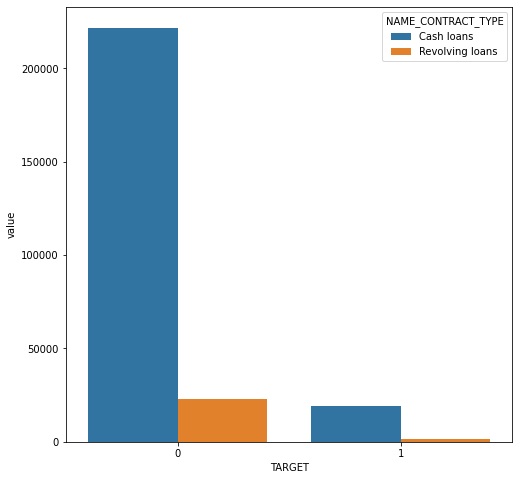

object CODE_GENDER


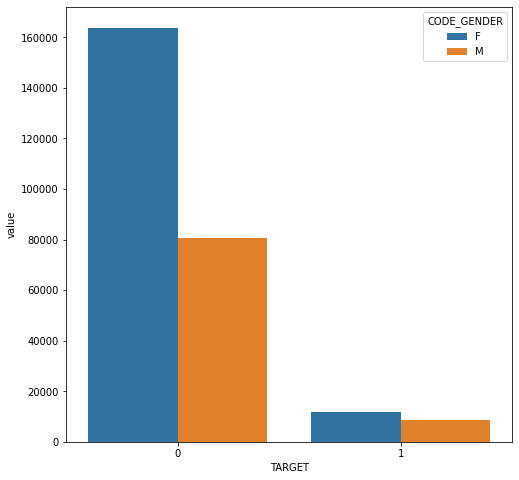

object FLAG_OWN_CAR


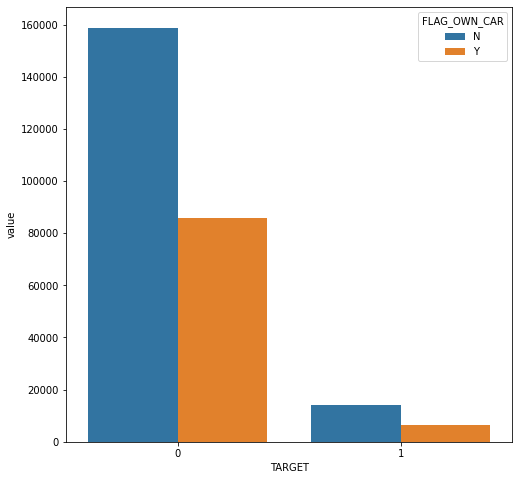

object FLAG_OWN_REALTY


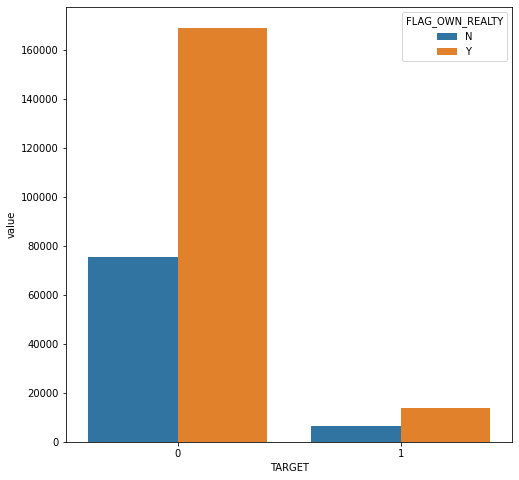

object NAME_TYPE_SUITE


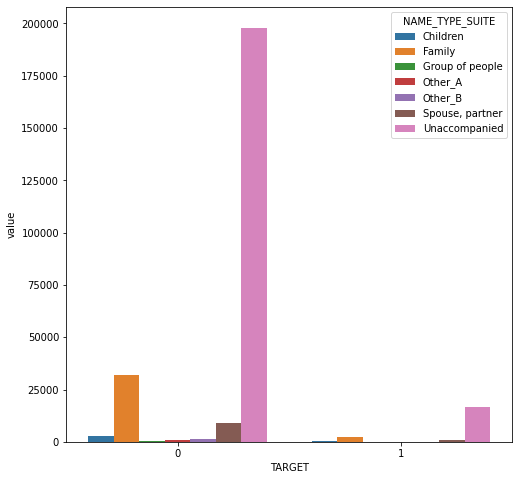

object NAME_INCOME_TYPE


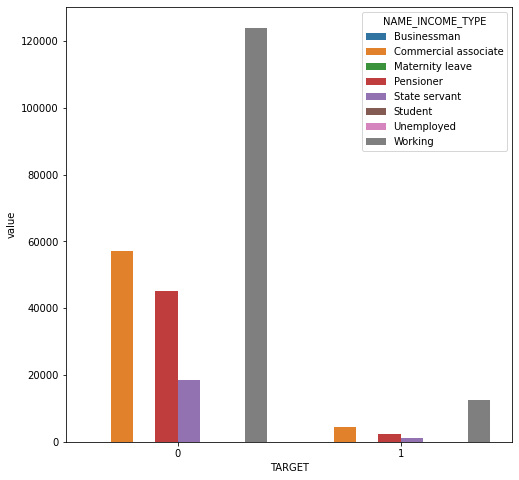

object NAME_EDUCATION_TYPE


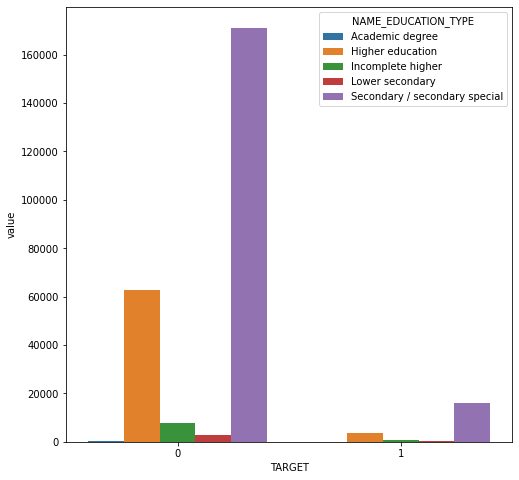

object NAME_FAMILY_STATUS


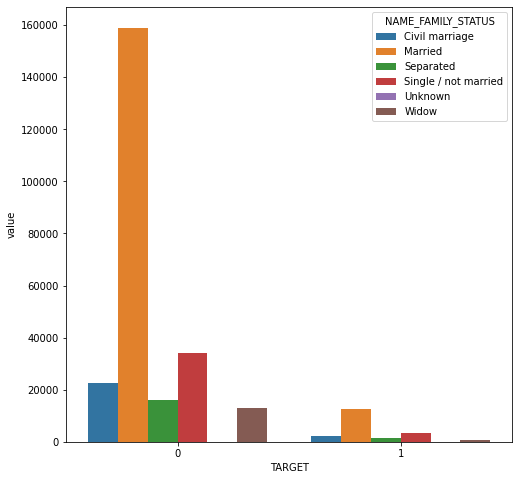

object NAME_HOUSING_TYPE


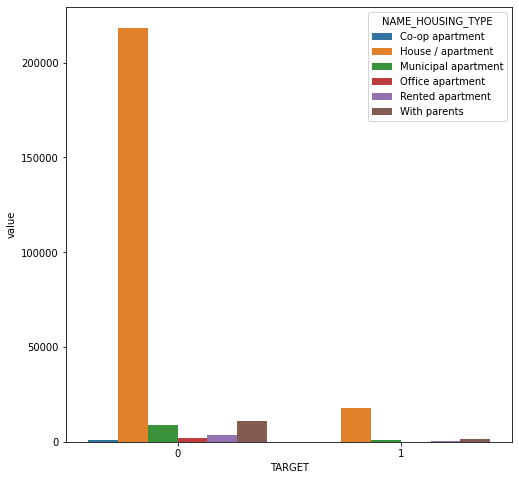

object WEEKDAY_APPR_PROCESS_START


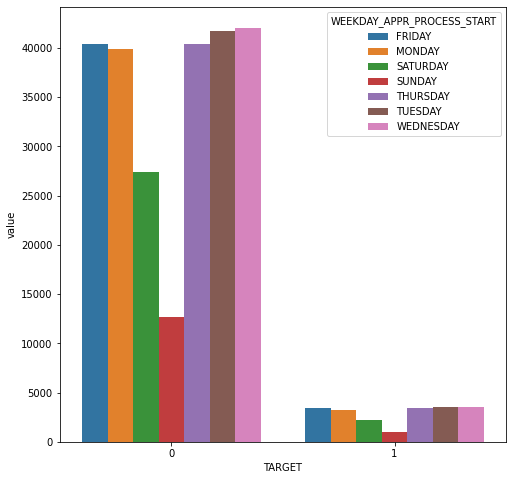

object EMERGENCYSTATE_MODE


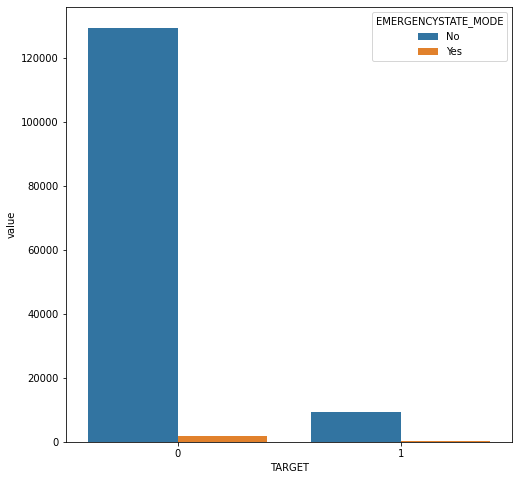

In [24]:
print('category variables distribustion')
vp.stack_bar(df,stack_cols,y_name)

### Visual analysis distribution of numerical variables respect to target variable

numeric variables distribustion


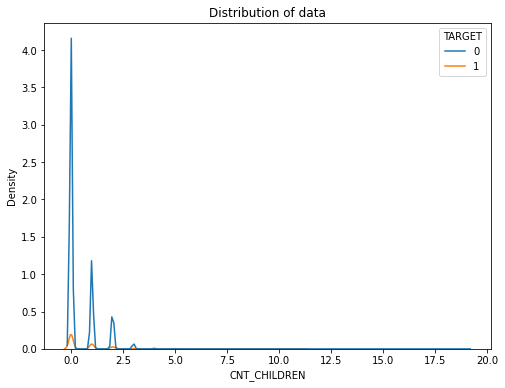

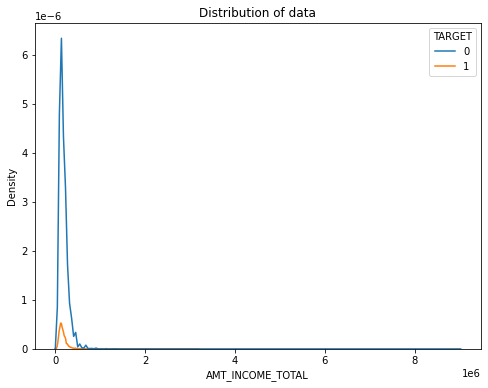

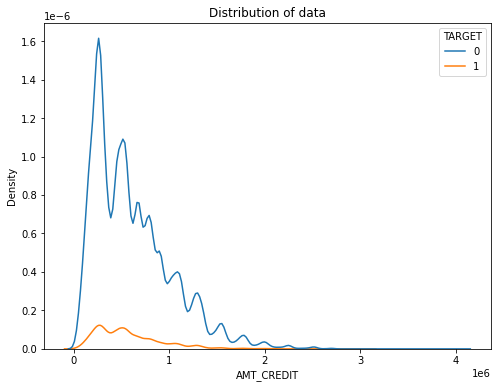

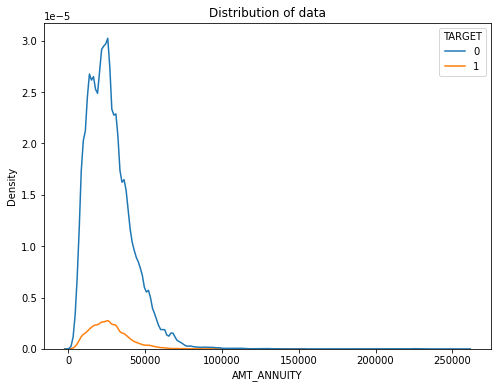

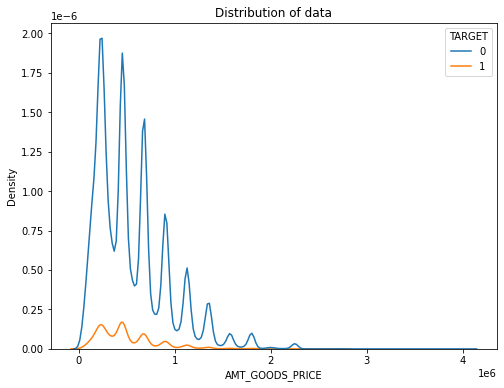

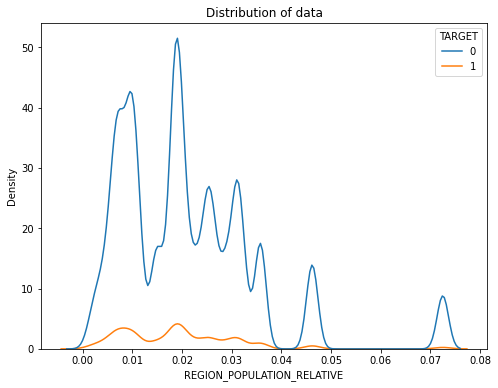

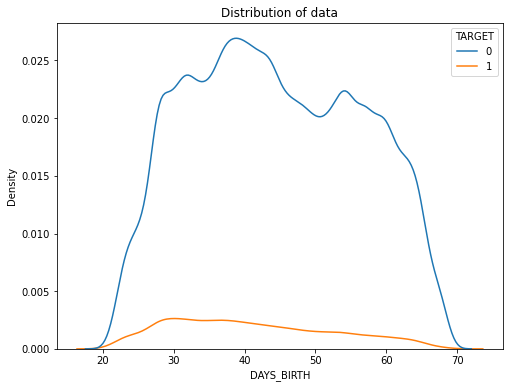

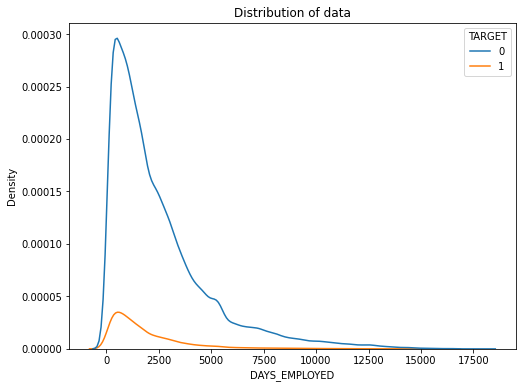

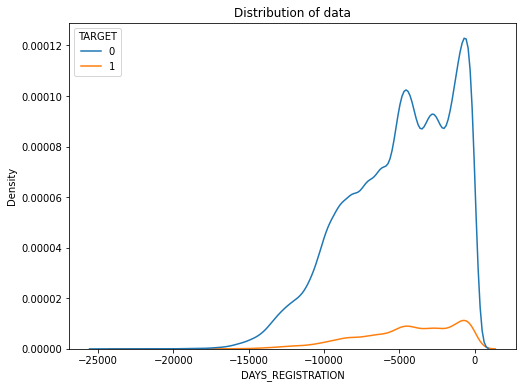

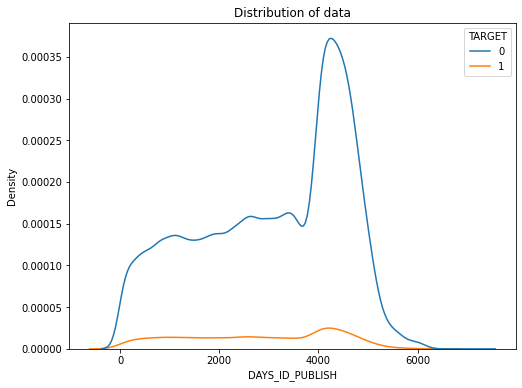

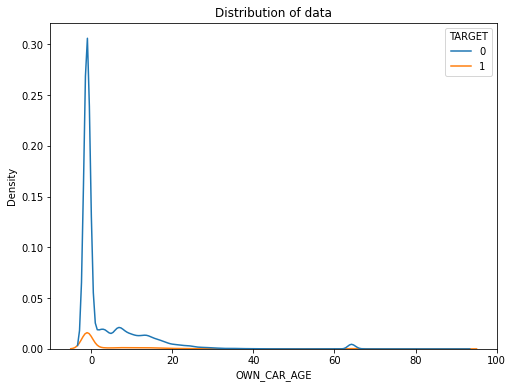

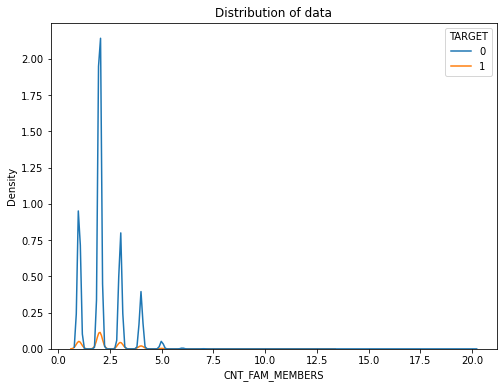

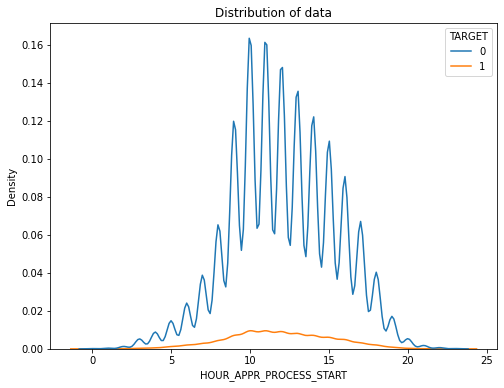

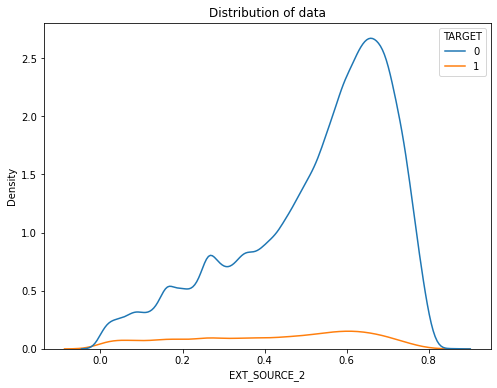

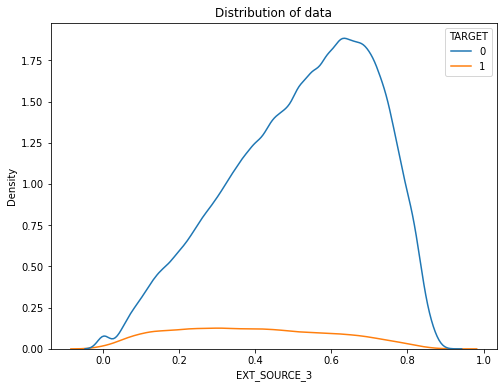

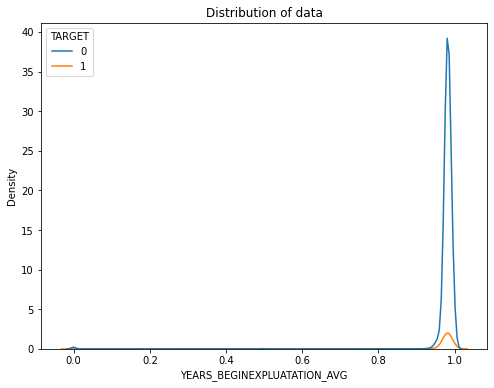

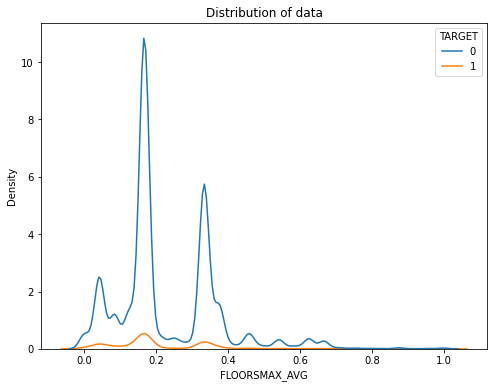

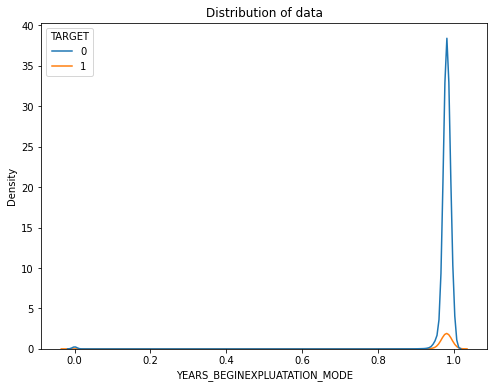

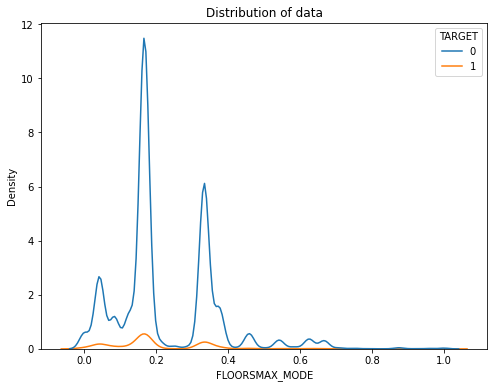

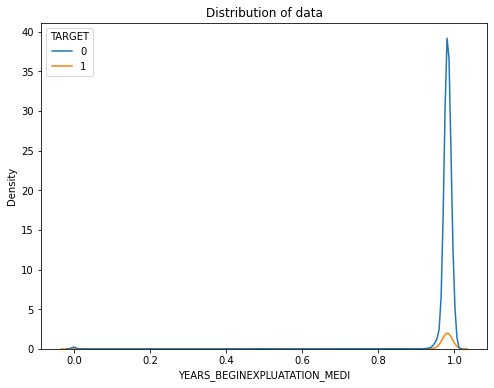

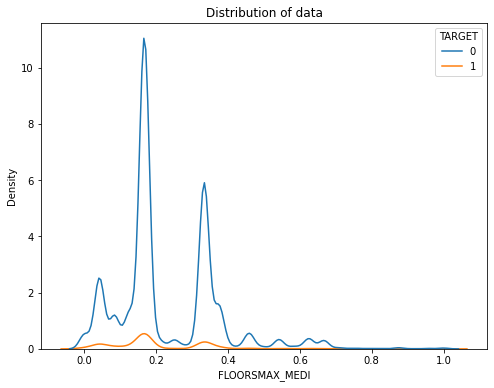

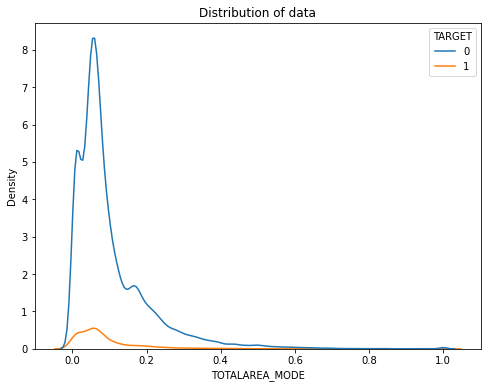

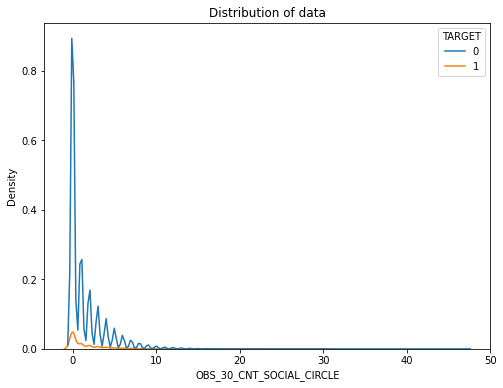

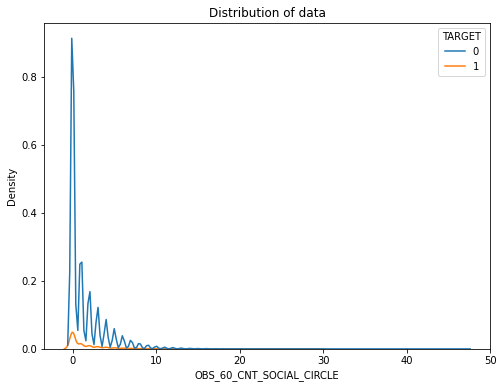

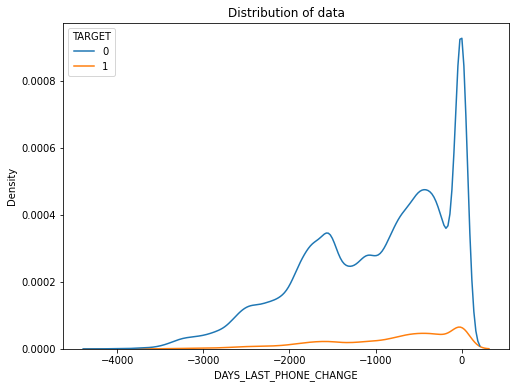

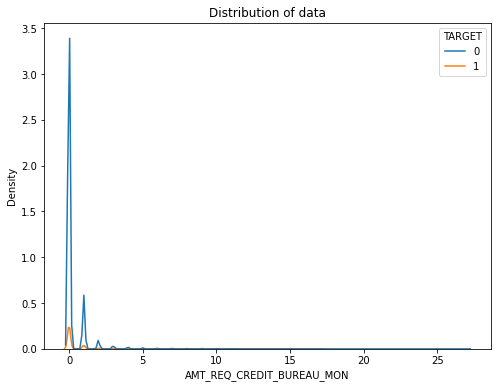

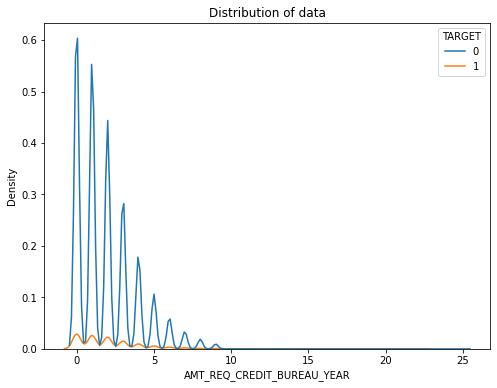

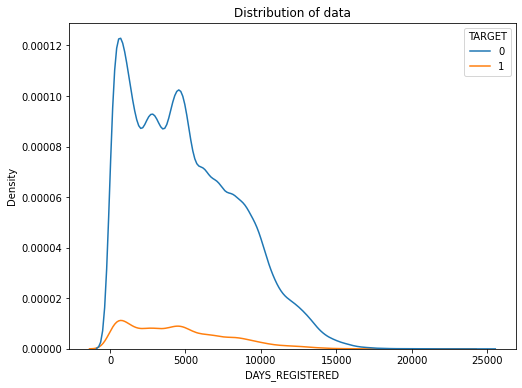

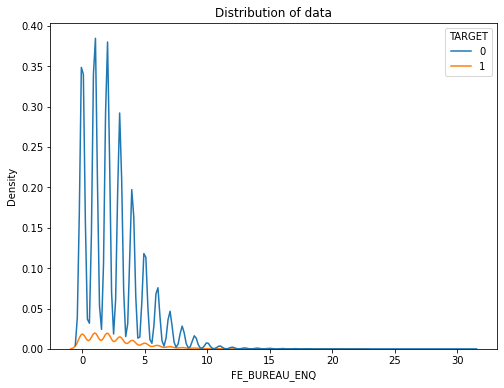

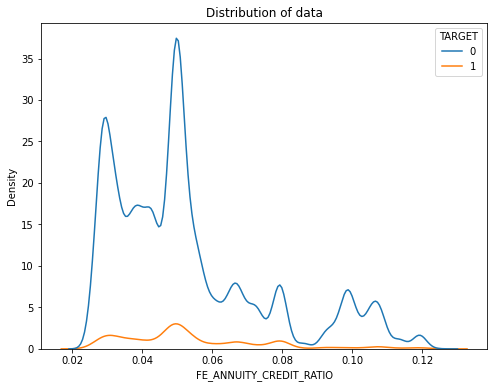

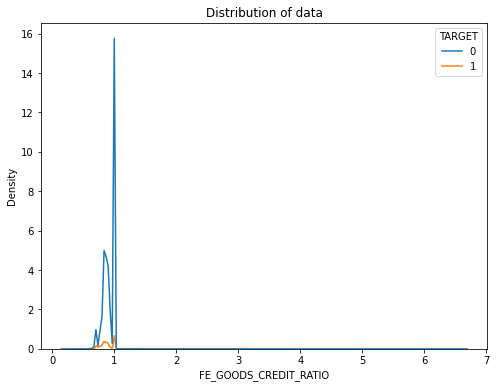

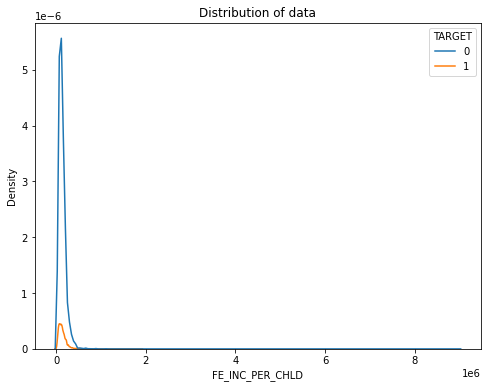

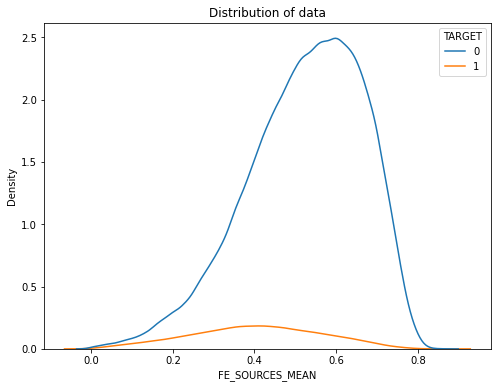

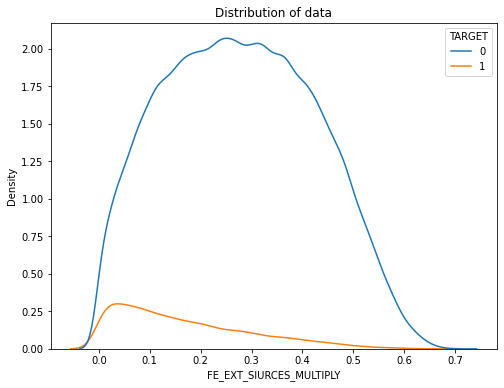

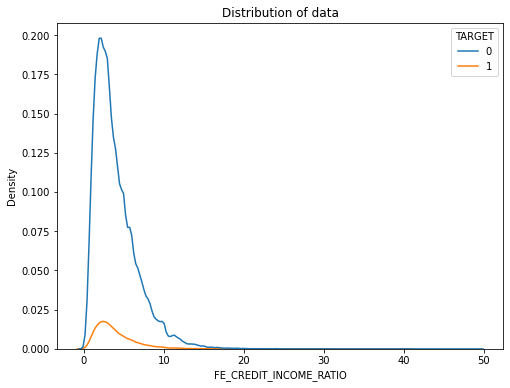

In [25]:
print('numeric variables distribustion')
vp.dist_bar(df,float_cols,y_name)

### Merging the data with meta data

In [26]:
df = md.train_df(df)

 
 bureau.csv contains 1716428 rows and 17 columns 
 
 bureau_balance.csv contains 27299925 rows and 3 columns 
 
 POS_CASH_balance.csv contains 10001358 rows and 8 columns 
 
 credit_card_balance.csv contains 3840312 rows and 23 columns 
 
 previous_application.csv contains 1670214 rows and 37 columns 
 
 installments_payments.csv contains 13605401 rows and 8 columns 

--------aggrigation---------

-------bureau_balance ----------
Total number of dropped columns for threshold 0.6: 0
Total number of columns with missing value :0
Columns dropped : []
 shape of merged df = (1716428, 27)

----------- bureau ---------- 
Total number of dropped columns for threshold 0.6: 2
Total number of columns with missing value :14
Columns dropped : ['AMT_CREDIT_MAX_OVERDUE', 'AMT_ANNUITY']
 shape of merged df = (265134, 169)

------- POS_CASH_balance ------------
Total number of dropped columns for threshold 0.6: 0
Total number of columns with missing value :2
Columns dropped : []
 shape of merged df =

In [27]:
df = cf.missing_value_analysis(df, 0.45)

Total number of dropped columns for threshold 0.45: 79
Total number of columns with missing value :331
Columns dropped : ['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'credit_SK_ID_CURR_MIN', 'credit_SK_ID_CURR_MAX', 'credit_SK_ID_CURR_MEAN', 'credit_MONTHS_BALANCE_MIN', 'credit_MONTHS_BALANCE_MAX', 'credit_MONTHS_BALANCE_MEAN', 'credit_AMT_BALANCE_MIN', 'credit_AMT_BALANCE_MAX', 'credit_AMT_BALANCE_MEAN', 'credit_AMT_CREDIT_LIMIT_ACTUAL_MIN', 'credit_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'credit_AMT_CREDIT_LIMIT_ACTUAL_MEAN', 'credit_AMT_DRAWINGS_ATM_CURRENT_MIN', 'credit_AMT_DRAWINGS_ATM_CURRENT_MAX', 'credit_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'credit_AMT_DRAWINGS_CURRENT_MIN', 'credit_AMT_DRAWINGS_CURRENT_MAX', 'credit_AMT_DRAWINGS_CURRENT_MEAN', 'credit_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'credit_AMT_DRAWINGS_OTHER_CURRENT_MAX', 'credit_AMT_DRAWINGS_OTHE

### SKEW correction

 
 	 	 skewness after transformation 
 
             	 	 	  before correction 	 after correction 
	 AMT_INCOME_TOTAL  :  8.52 	 	 0.15


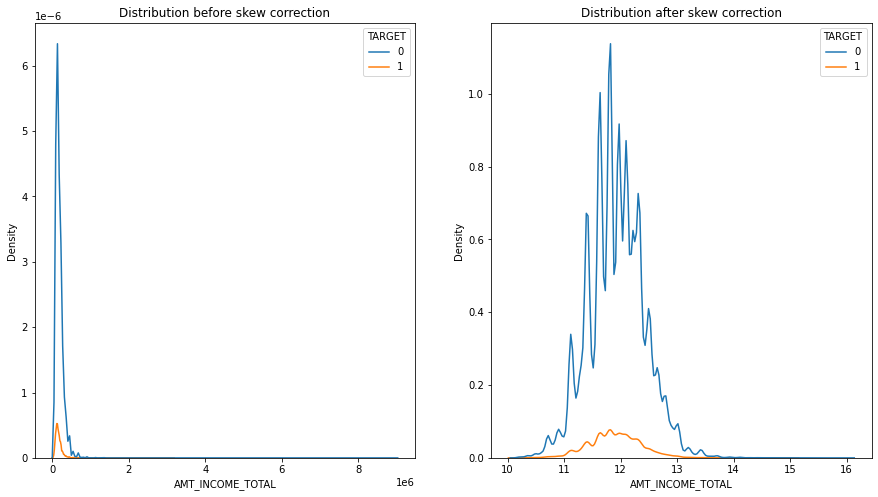

	 AMT_CREDIT  :  1.22 	 	 -0.36


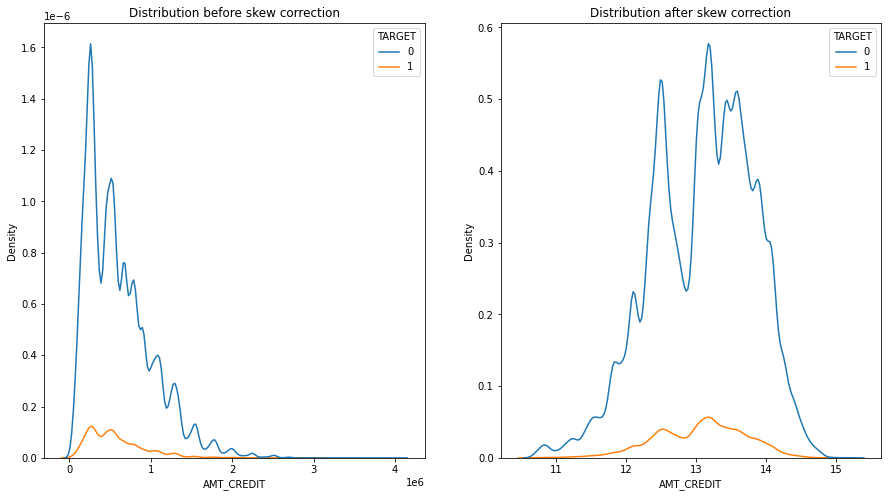

	 AMT_ANNUITY  :  1.54 	 	 -0.36


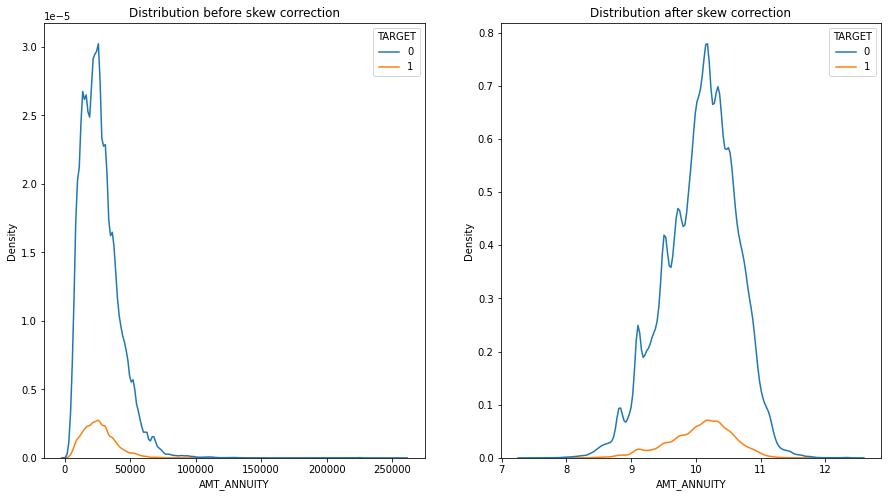

	 AMT_GOODS_PRICE  :  1.33 	 	 -0.31


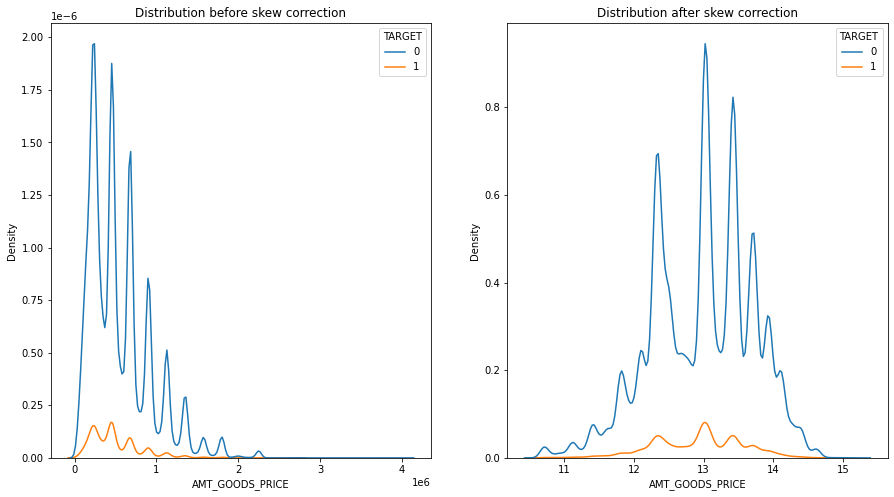

	 REGION_POPULATION_RELATIVE  :  1.49 	 	 1.43


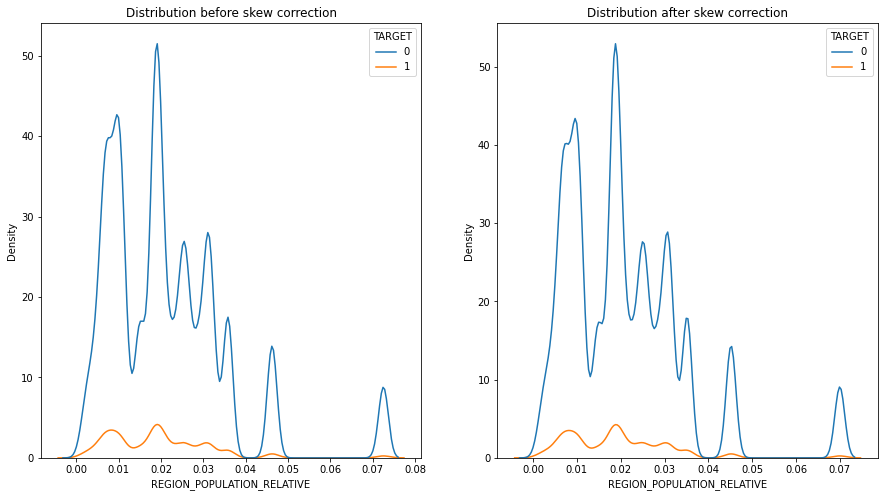

	 CNT_FAM_MEMBERS  :  0.99 	 	 0.12


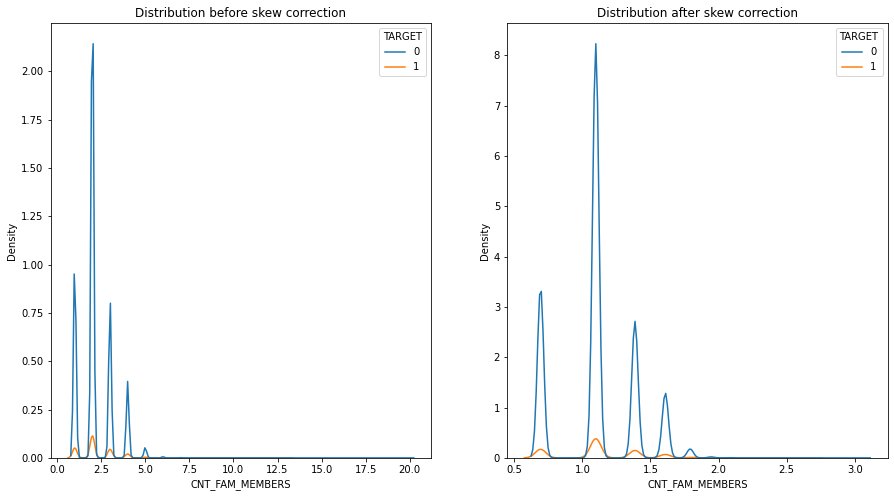

	 FE_ANNUITY_CREDIT_RATIO  :  1.14 	 	 1.1


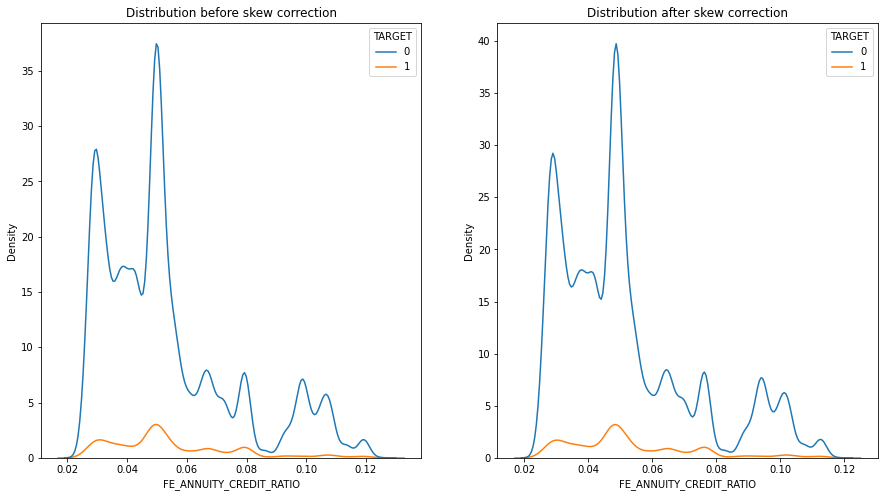

	 FE_GOODS_CREDIT_RATIO  :  2.89 	 	 0.24


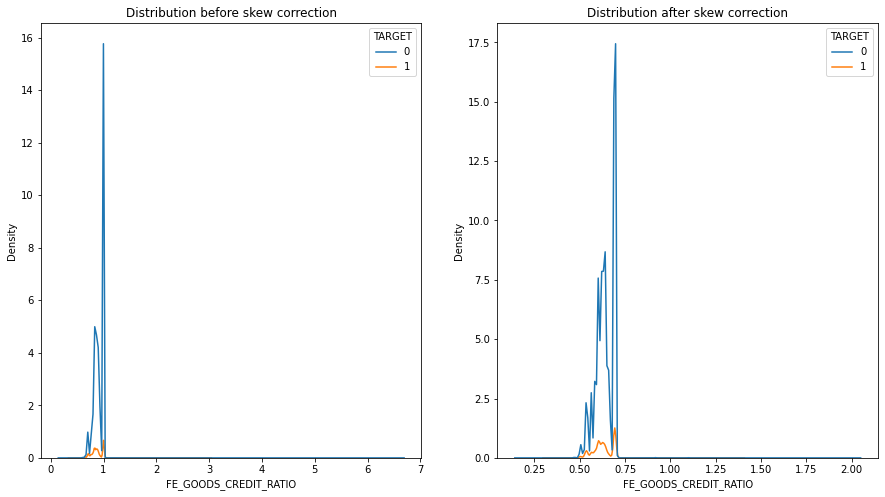

	 FE_INC_PER_CHLD  :  8.44 	 	 -0.23


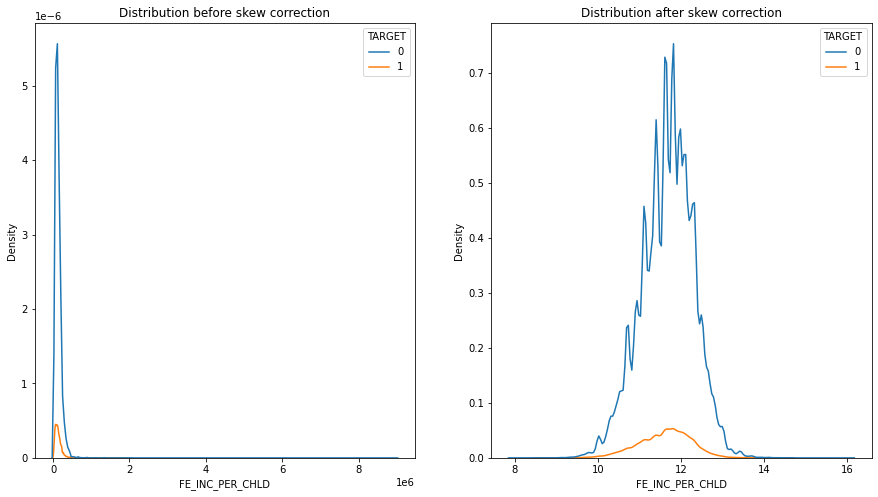

	 FE_CREDIT_INCOME_RATIO  :  1.73 	 	 0.2


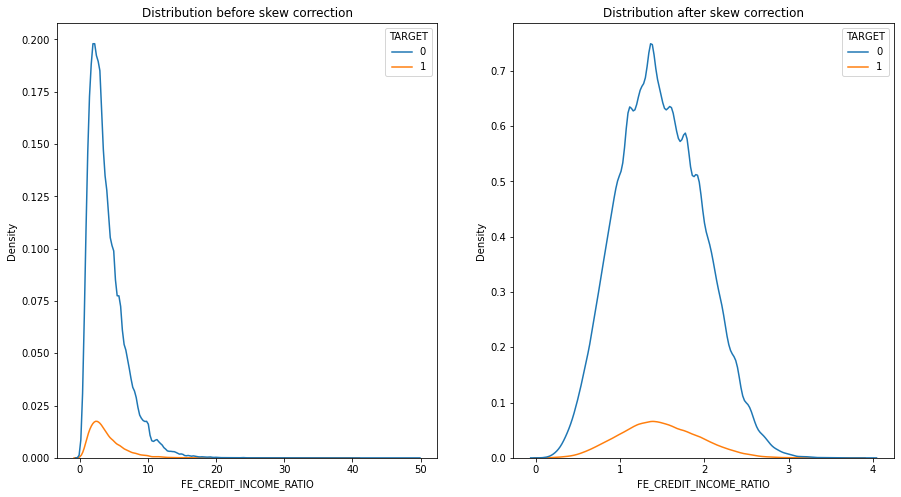

	 bu_bucount_  :  1.82 	 	 0.1


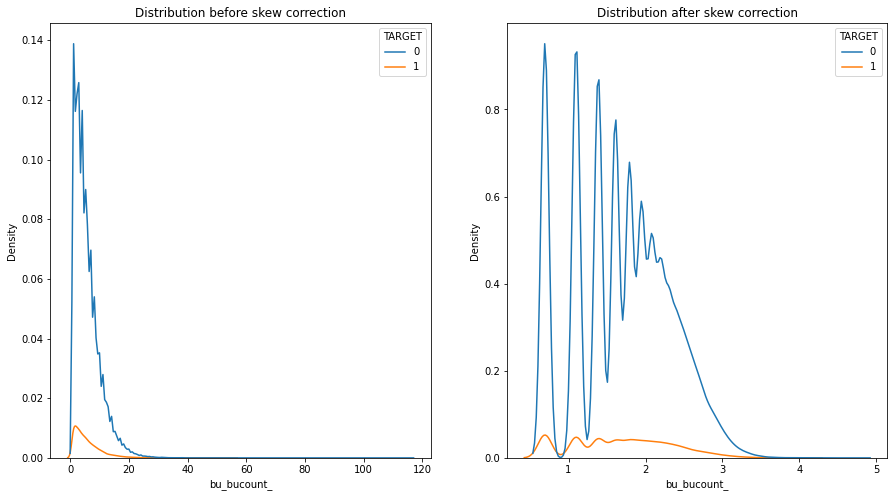

	 pos_poscount_  :  1.8 	 	 -0.01


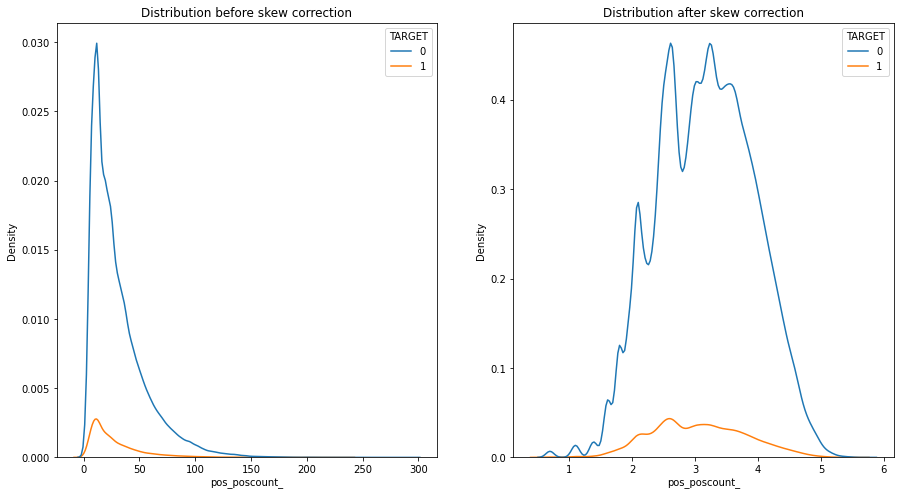

	 inst_NUM_INSTALMENT_NUMBER_MIN  :  24.43 	 	 15.8


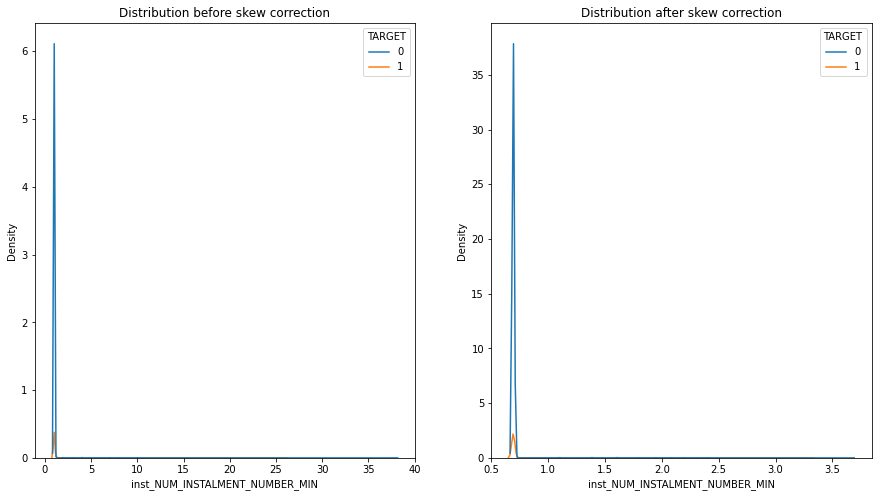

	 inst_NUM_INSTALMENT_NUMBER_MAX  :  2.41 	 	 0.9


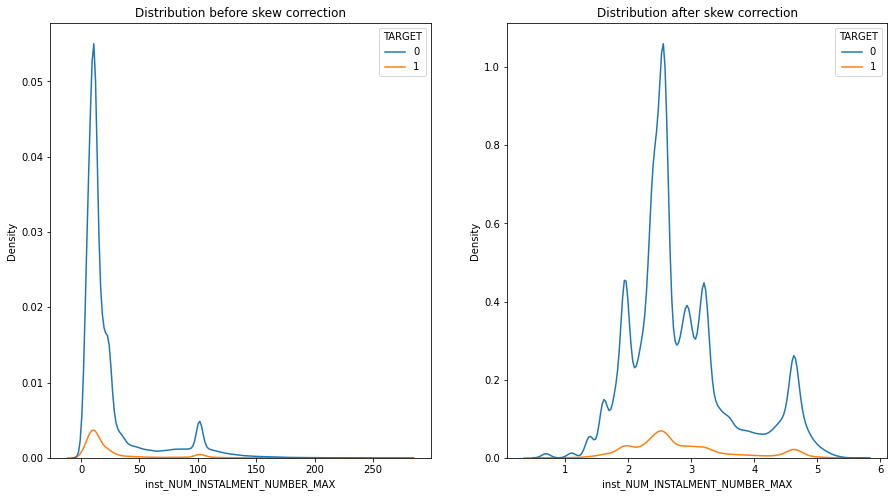

	 inst_NUM_INSTALMENT_NUMBER_MEAN  :  3.33 	 	 1.29


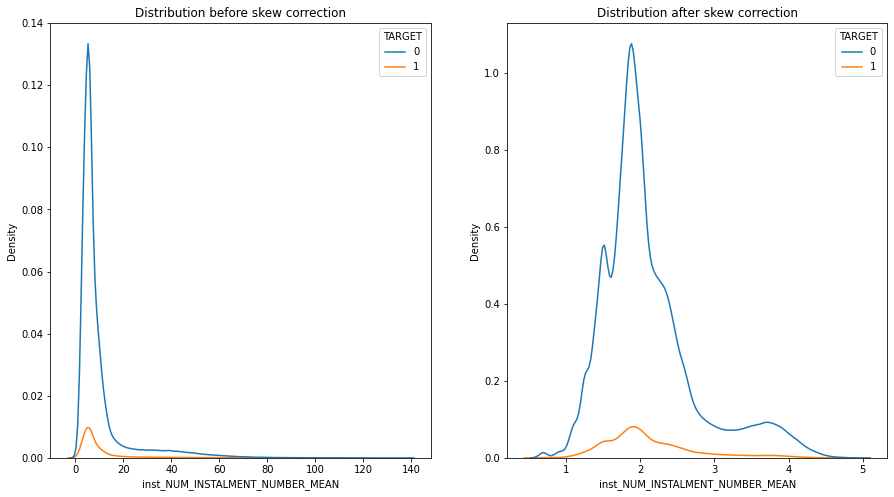

	 inst_instcount_  :  1.95 	 	 0.08


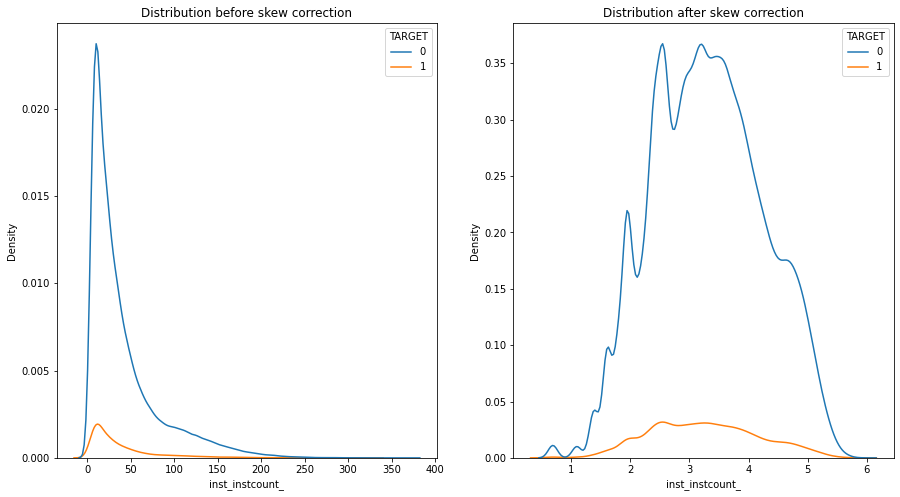

	 prev_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN  :  -11.9 	 	 -12.97


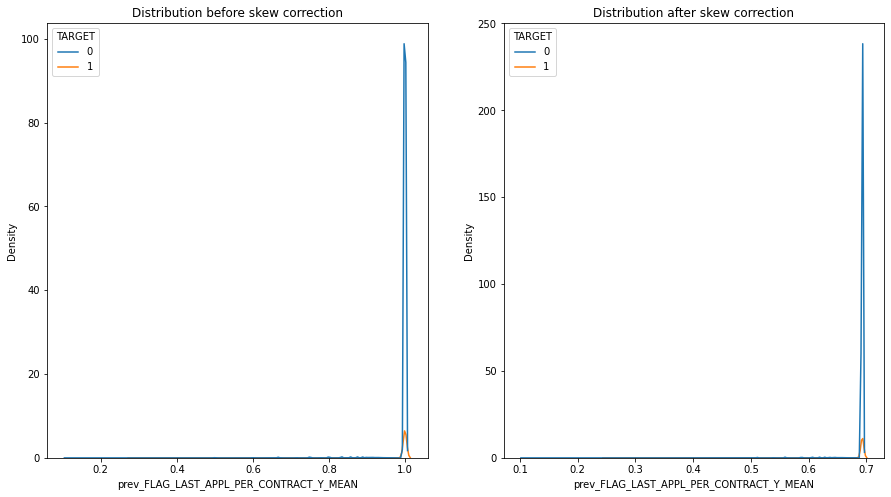

	 prev_prevcount_  :  2.3 	 	 0.27


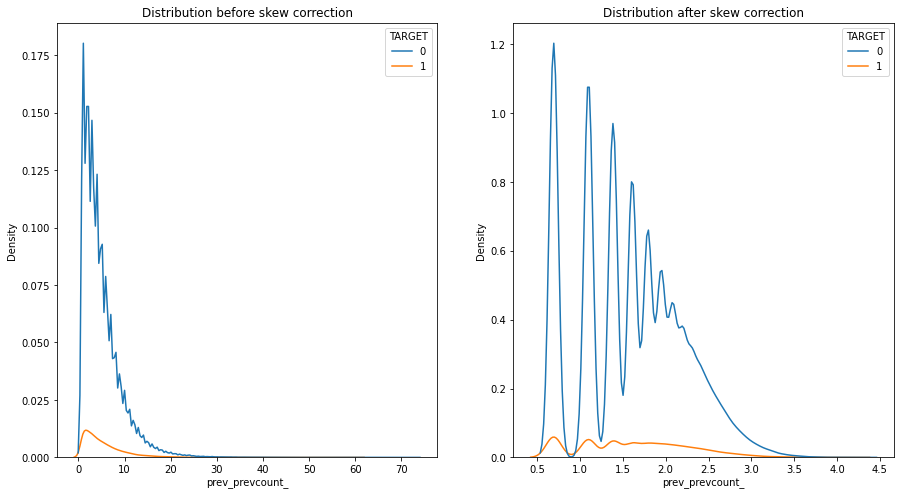

skew corrected for Total number of columns :  18


In [28]:
viusalise = 1
dup_df = df.copy()
i = 0

print(''' \n \t \t skewness after transformation \n 
             \t \t \t  before correction \t after correction ''')

for col in df.columns:
    if df[col].dtype != 'O' and len(df[col].unique())>10 :
        if (df[col].skew() > 0.9 or df[col].skew() < -0.9) and (min(df[col])>0):
            i+=1
            df[col] = np.log1p(df[col])
            print('\t',col,' : ',round(dup_df[col].skew(),2),'\t \t',round(df[col].skew(),2))


            if viusalise:
                fig, ax = plt.subplots(figsize=(15,8))
                plt.subplot(1,2,1)
                plt.title('Distribution before skew correction')
                sns.kdeplot(data=dup_df, x=col, hue='TARGET')

                plt.subplot(1,2,2)
                plt.title('Distribution after skew correction')
                sns.kdeplot(data=df, x=col, hue='TARGET')

                plt.show ()  
            

#                 if  (df[col].skew() > 0.9 or df[col].skew() < -0.9):

# #                     print(col,f''' skew before correction : {dup_df[col].skew()}
# # skew after correction : {df[col].skew()} \n''')


print('skew corrected for Total number of columns : ',i)

### Scaling numerical numbers

In [29]:
num_df = df.select_dtypes(exclude='O') 
num_df = num_df.drop('TARGET',axis=1)
num_cols = num_df.columns

scalaed = StandardScaler()
scaled_df = scalaed.fit_transform(num_df)   
num_df = pd.DataFrame(scaled_df, columns=num_cols)

for col in num_df.columns:
    df[col] = num_df[col]

### Encoding categorical variables

In [30]:
print("Shape of the df before encoding = ",df.shape)
df = cf.one_hot_enc(df, nan_as_category=False)
print("Shape of the df after encoding = ",df.shape)

Shape of the df before encoding =  (265134, 406)
Shape of the df after encoding =  (265134, 518)


### Defining variables

In [31]:
df = df.fillna(-999)
y = df[y_name]
x = df.drop([y_name,'SK_ID_CURR'],axis=1)
print(x.shape)

(265134, 516)


### Cross validation

In [32]:
best_model = cl.XGBClassifier()
pl.kfold_cross_validate(best_model, x, y,100)

[12:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Over sampling for train data

In [33]:
x_train,x_test,y_train,y_test=ms.train_test_split(x,y,test_size=0.3, random_state=89)

In [34]:
x_train,y_train = pl.oversampling(x_train,y_train)
x_train = pd.DataFrame(x_train)
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(342604, 516)
(342604,)
0    171302
1    171302
Name: TARGET, dtype: int64


In [35]:
#reducing the size of data frame
df = cf.convert_types(df,print_info = True)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.45 gb.


### Feature Importance

In [42]:
fe_model = XGBClassifier(learning_rate =0.1, 
        n_estimators=100, max_depth=10, min_child_weight=8, subsample=0.8, 
        colsample_bytree=0.8, objective= 'binary:logistic', n_jobs = -1,
        nthread=4, seed=27, reg_lambda = 1.2,missing = -999,colsample_bylevel= 0.5,
        scale_pos_weight=1.5)

fe_model.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train, 
        y_train),(x_test, y_test)],verbose = 10)

[0]	validation_0-auc:0.92262	validation_1-auc:0.66322
[10]	validation_0-auc:0.97938	validation_1-auc:0.71901
[20]	validation_0-auc:0.98429	validation_1-auc:0.73068
[30]	validation_0-auc:0.98820	validation_1-auc:0.74059
[40]	validation_0-auc:0.99098	validation_1-auc:0.74900
[50]	validation_0-auc:0.99275	validation_1-auc:0.75416
[60]	validation_0-auc:0.99413	validation_1-auc:0.75788
[70]	validation_0-auc:0.99528	validation_1-auc:0.76086
[80]	validation_0-auc:0.99624	validation_1-auc:0.76225
[90]	validation_0-auc:0.99691	validation_1-auc:0.76417
[99]	validation_0-auc:0.99737	validation_1-auc:0.76555


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=8, missing=-999, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1.2,
              scale_pos_weight=1.5, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [43]:
test_pred = fe_model.predict(x_test)
train_pred = fe_model.predict(x_train)

Training:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    171302
           1       1.00      0.94      0.97    171302

    accuracy                           0.97    342604
   macro avg       0.97      0.97      0.97    342604
weighted avg       0.97      0.97      0.97    342604

Testing:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     73328
           1       0.43      0.07      0.12      6213

    accuracy                           0.92     79541
   macro avg       0.68      0.53      0.54     79541
weighted avg       0.89      0.92      0.89     79541

ROC AUC score :  0.5316075783519517
confusion matrix: /n [[72735   593]
 [ 5770   443]]
fi count--> 516


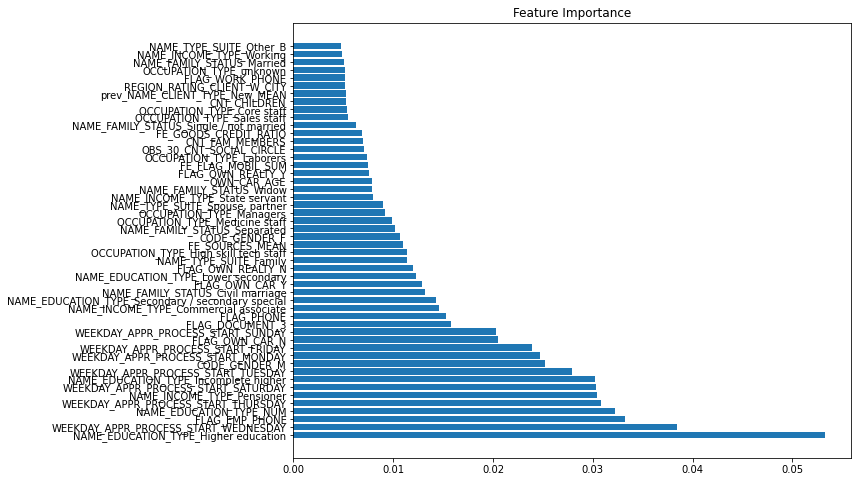

In [44]:
print("Training:")
print(classification_report(y_train, train_pred))
print("Testing:")
print(classification_report(y_test, test_pred))
print('ROC AUC score : ',roc_auc_score(y_test, test_pred))
print('confusion matrix: /n',confusion_matrix(y_test, test_pred))


fi = fe_model.feature_importances_; print("fi count-->", len(fi))
fi_dict={}

for i in range(x.shape[1]):  
    fi_dict[x.columns[i]] = fi[i]
fi_dict = pl.sort_by_value(fi_dict)
#print([k for k,v in fi_dict])

feat_imp = pd.DataFrame(fi_dict, columns=['name','value'])

plt.figure(figsize=(10,8))
plt.barh(feat_imp['name'][:50],feat_imp['value'][:50])
plt.title('Feature Importance')
plt.show()

### Model building

In [45]:
print("Shape of training dataset : ",x_train.shape)
np.random.seed(89)

model = LogisticRegression(random_state=89)
model.fit(x_train, y_train)

Shape of training dataset :  (342604, 516)


LogisticRegression(random_state=89)

In [46]:
test_pred = model.predict(x_test)
train_pred = model.predict(x_train)

Model evaluation

Training:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70    171302
           1       0.70      0.67      0.68    171302

    accuracy                           0.69    342604
   macro avg       0.69      0.69      0.69    342604
weighted avg       0.69      0.69      0.69    342604

Testing:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     73328
           1       0.14      0.56      0.22      6213

    accuracy                           0.70     79541
   macro avg       0.54      0.63      0.52     79541
weighted avg       0.89      0.70      0.76     79541

ROC AUC score :  0.6337919150364265
confusion matrix: /n [[51830 21498]
 [ 2729  3484]]
####confusion matrix#####


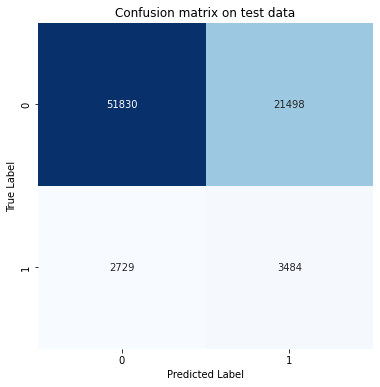

###### AUC - ROC #######
# Plot the ROC graph


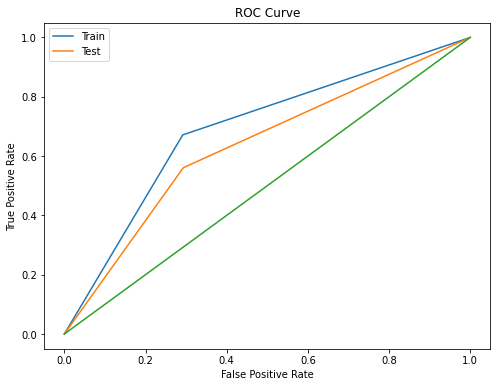

In [47]:
print("Training:")
print(classification_report(y_train, train_pred))
print("Testing:")
print(classification_report(y_test, test_pred))
print('ROC AUC score : ',roc_auc_score(y_test, test_pred))
print('confusion matrix: /n',confusion_matrix(y_test, test_pred))

print('####confusion matrix#####')

cm_test=confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,6))
plt.title('Confusion matrix on test data')
sns.heatmap(cm_test, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print('###### AUC - ROC #######')

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, train_pred)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, test_pred)

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)


print('# Plot the ROC graph')
plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()